In [1]:
import pandas as pd

def combine_csv_with_tags_and_wards(csv_file_tags, csv_file_wards, output_csv):

    df_tags = pd.read_csv(csv_file_tags)
      

    df_wards = pd.read_csv(csv_file_wards)
    

    df_tags_wards = pd.merge(df_tags, df_wards, on=['latitude', 'longitude', 'line_number'], how='inner')
    
    print(df_tags_wards.head(10))
    #df_tags_wards.to_csv(output_csv, index=False)
    

    return df_tags_wards

csv_file_tags = 'Chicago_tags.csv'  
csv_file_wards = 'Chicago_ward_precinct.csv'  

output_csv = 'Chicago_completo.csv'  

df_tags_wards = combine_csv_with_tags_and_wards(csv_file_tags, csv_file_wards,  output_csv)


    latitude  longitude  line_number             picture  \
0  41.699542 -87.690806            5   street_view_4.jpg   
1  41.736580 -87.572423            6   street_view_5.jpg   
2  41.996630 -87.728055           20  street_view_19.jpg   
3  41.872340 -87.726487           23  street_view_22.jpg   
4  41.843702 -87.657161           24  street_view_23.jpg   
5  41.789026 -87.788659           27  street_view_26.jpg   
6  41.950305 -87.757359           35  street_view_34.jpg   
7  41.785911 -87.670104           36  street_view_35.jpg   
8  41.994415 -87.717418           45  street_view_44.jpg   
9  41.944126 -87.833558           53  street_view_52.jpg   

                                                tags  WARD  PRECINCT  
0  car | estate | home | house | house exterior |...  19.0      46.0  
1  apartment | bin | building | car | chimney | c...   8.0       4.0  
2  car | construction site | dirt road | dirt tra...  39.0      36.0  
3  ambulance | car | home | house | house exterio...  2

In [10]:
allowed_tags = ["apartment", "church", "garage", "house", "industrial", "office building", 
                    "retail", "roof", "sidewalk", "porch", "urban", "suburb"]

def filter_tags(tag_str):
        if pd.isna(tag_str):
            return None

        filtered_tags = [tag.strip() for tag in tag_str.split('|') if tag.strip() in allowed_tags]

        return ' | '.join(filtered_tags) if filtered_tags else None


df_tags_wards['tags'] = df_tags_wards['tags'].apply(filter_tags)

print(df_tags_wards.head(10))

    latitude  longitude  line_number             picture  \
0  41.699542 -87.690806            5   street_view_4.jpg   
1  41.736580 -87.572423            6   street_view_5.jpg   
2  41.996630 -87.728055           20  street_view_19.jpg   
3  41.872340 -87.726487           23  street_view_22.jpg   
4  41.843702 -87.657161           24  street_view_23.jpg   
5  41.789026 -87.788659           27  street_view_26.jpg   
6  41.950305 -87.757359           35  street_view_34.jpg   
7  41.785911 -87.670104           36  street_view_35.jpg   
8  41.994415 -87.717418           45  street_view_44.jpg   
9  41.944126 -87.833558           53  street_view_52.jpg   

                         tags  WARD  PRECINCT  
0              house | suburb  19.0      46.0  
1  apartment | house | suburb   8.0       4.0  
2                      retail  39.0      36.0  
3              house | suburb  24.0      20.0  
4           apartment | house  11.0       1.0  
5              house | suburb  23.0      12.0  
6  

In [11]:
def process_ward_precinct_tags(df_combined):


    all_tags = df_combined['tags'].dropna().str.split(' | ').explode().unique()
    

    results = []

    grouped = df_combined.groupby(['WARD', 'PRECINCT'])
    

    for (ward, precinct), group in grouped:

        tag_counts = {}
        

        total_count = len(group)

        for tag in all_tags:
            tag_counts[tag] = 0
        

        for tags_str in group['tags'].dropna():
            tags = tags_str.split(' | ')
            for tag in tags:
                if tag in tag_counts:
                    tag_counts[tag] += 1
        

        tag_counts_normalized = {tag: count / total_count for tag, count in tag_counts.items()}
        

        row = {'WARD': ward, 'PRECINCT': precinct}
        row.update(tag_counts_normalized)
        

        results.append(row)

    df_tags_summary = pd.DataFrame.from_records(results)
    
    return df_tags_summary


df_tags_summary = process_ward_precinct_tags(df_tags_wards)


print(df_tags_summary.head(10))


#df_tags_summary.to_csv('summary_tags_ward_precinct.csv', index=False)

   WARD  PRECINCT     house    |    suburb  apartment    retail    garage  \
0   1.0       1.0  0.666667  0.0  0.666667   0.000000  0.333333  0.666667   
1   1.0       2.0  0.500000  0.0  0.500000   0.000000  1.000000  1.000000   
2   1.0       3.0  0.333333  0.0  0.000000   0.333333  0.666667  0.333333   
3   1.0       4.0  0.333333  0.0  0.000000   0.000000  0.666667  0.333333   
4   1.0       5.0  0.500000  0.0  0.000000   1.000000  0.500000  0.500000   
5   1.0       6.0  0.333333  0.0  0.222222   1.000000  0.444444  0.222222   
6   1.0       7.0  0.666667  0.0  0.333333   0.000000  0.666667  0.333333   
7   1.0       8.0  0.000000  0.0  0.000000   0.666667  1.000000  0.000000   
8   1.0       9.0  0.000000  0.0  0.000000   0.000000  1.000000  0.000000   
9   1.0      10.0  0.250000  0.0  0.250000   0.750000  0.750000  0.250000   

      urban  office  building      roof  porch  church  
0  0.000000     0.0       0.0  0.000000    0.0     0.0  
1  0.000000     0.0       0.0  0.00000

In [13]:
if '|' in df_tags_summary.columns:
    df_tags_summary = df_tags_summary.drop(columns=['|'])
print(df_tags_summary.columns)

Index(['WARD', 'PRECINCT', 'house', 'suburb', 'apartment', 'retail', 'garage',
       'urban', 'office', 'building', 'roof', 'porch', 'church'],
      dtype='object')


In [14]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
df_votes = pd.read_stata(chicago_votes)


df_votes.rename(columns={'ward2012': 'WARD', 'precinct2012': 'PRECINCT'}, inplace=True)

df_tags_summary_copy = df_tags_summary.copy()

tags_votes_df = pd.merge(df_tags_summary_copy, df_votes[['WARD', 'PRECINCT', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r']], 
                     on=['WARD', 'PRECINCT'], how='left')

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


tags_votes_df['Y'] = tags_votes_df.apply(calculate_y, axis=1)

print(tags_votes_df.head(10))


#tags_votes_df.to_csv('chicago_tags_votes.csv', index=False)

   WARD  PRECINCT     house    suburb  apartment    retail    garage  \
0   1.0       1.0  0.666667  0.666667   0.000000  0.333333  0.666667   
1   1.0       2.0  0.500000  0.500000   0.000000  1.000000  1.000000   
2   1.0       3.0  0.333333  0.000000   0.333333  0.666667  0.333333   
3   1.0       4.0  0.333333  0.000000   0.000000  0.666667  0.333333   
4   1.0       5.0  0.500000  0.000000   1.000000  0.500000  0.500000   
5   1.0       6.0  0.333333  0.222222   1.000000  0.444444  0.222222   
6   1.0       7.0  0.666667  0.333333   0.000000  0.666667  0.333333   
7   1.0       8.0  0.000000  0.000000   0.666667  1.000000  0.000000   
8   1.0       9.0  0.000000  0.000000   0.000000  1.000000  0.000000   
9   1.0      10.0  0.250000  0.250000   0.750000  0.750000  0.250000   

      urban  office  building      roof  porch  church  n_lightfoot_l_2019r  \
0  0.000000     0.0       0.0  0.000000    0.0     0.0                  176   
1  0.000000     0.0       0.0  0.000000    0.0   

In [15]:
tags_votes_df.to_csv('chicago_tags_votes.csv', index=False)

In [3]:
import pandas as pd
import statsmodels.api as sm

csv_tags_votes = 'chicago_tags_votes.csv'

df_tags_votes = pd.read_csv(csv_tags_votes)

X = df_tags_votes.drop(columns=['WARD', 'PRECINCT', 'n_lightfoot_l_2019r','n_preckwinkle_t_2019r', 'Y'])


y = df_tags_votes['Y'].dropna()

X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     13.44
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           4.36e-21
Time:                        12:36:30   Log-Likelihood:                 675.91
No. Observations:                1898   AIC:                            -1332.
Df Residuals:                    1888   BIC:                            -1276.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6067      0.013     48.104      0.0

CENSUS

In [21]:
import pandas as pd

def combine_csv_with_tags_and_wards(csv_file_tags, csv_file_wards, output_csv):

    df_tags = pd.read_csv(csv_file_tags)
      

    df_wards = pd.read_csv(csv_file_wards)
    

    df_tags_wards = pd.merge(df_tags, df_wards, on=['latitude', 'longitude', 'line_number'], how='inner')
    
    print(df_tags_wards.head(10))
    #df_tags_wards.to_csv(output_csv, index=False)
    

    return df_tags_wards

csv_file_tags = 'Chicago_tags.csv'  
csv_file_wards = 'Chicago_tracts_pic.csv'  

output_csv = 'Chicago_tracs_completo.csv'  

df_tags_tracts = combine_csv_with_tags_and_wards(csv_file_tags, csv_file_wards,  output_csv)

df_tags_tracts.head(3)


    latitude  longitude  line_number             picture  \
0  41.699542 -87.690806            5   street_view_4.jpg   
1  41.736580 -87.572423            6   street_view_5.jpg   
2  41.996630 -87.728055           20  street_view_19.jpg   
3  41.872340 -87.726487           23  street_view_22.jpg   
4  41.843702 -87.657161           24  street_view_23.jpg   
5  41.789026 -87.788659           27  street_view_26.jpg   
6  41.950305 -87.757359           35  street_view_34.jpg   
7  41.785911 -87.670104           36  street_view_35.jpg   
8  41.994415 -87.717418           45  street_view_44.jpg   
9  41.944126 -87.833558           53  street_view_52.jpg   

                                                tags      geoid10  
0  car | estate | home | house | house exterior |...  17031720500  
1  apartment | bin | building | car | chimney | c...  17031480100  
2  car | construction site | dirt road | dirt tra...  17031120300  
3  ambulance | car | home | house | house exterio...  17031261000  

,latitude,longitude,line_number,picture,tags,geoid10
0,41.699542,-87.690806,5,street_view_4.jpg,car | estate | home | house | house exterior |...,17031720500
1,41.736580,-87.572423,6,street_view_5.jpg,apartment | bin | building | car | chimney | c...,17031480100
2,41.996630,-87.728055,20,street_view_19.jpg,car | construction site | dirt road | dirt tra...,17031120300


In [22]:
allowed_tags = ["apartment", "church", "garage", "house", "industrial", "office building", 
                    "retail", "roof", "sidewalk", "porch", "urban", "suburb"]

def filter_tags(tag_str):
        if pd.isna(tag_str):
            return None

        filtered_tags = [tag.strip() for tag in tag_str.split('|') if tag.strip() in allowed_tags]

        return ' | '.join(filtered_tags) if filtered_tags else None


df_tags_tracts['tags'] = df_tags_tracts['tags'].apply(filter_tags)

print(df_tags_tracts.head(10))

    latitude  longitude  line_number             picture  \
0  41.699542 -87.690806            5   street_view_4.jpg   
1  41.736580 -87.572423            6   street_view_5.jpg   
2  41.996630 -87.728055           20  street_view_19.jpg   
3  41.872340 -87.726487           23  street_view_22.jpg   
4  41.843702 -87.657161           24  street_view_23.jpg   
5  41.789026 -87.788659           27  street_view_26.jpg   
6  41.950305 -87.757359           35  street_view_34.jpg   
7  41.785911 -87.670104           36  street_view_35.jpg   
8  41.994415 -87.717418           45  street_view_44.jpg   
9  41.944126 -87.833558           53  street_view_52.jpg   

                         tags      geoid10  
0              house | suburb  17031720500  
1  apartment | house | suburb  17031480100  
2                      retail  17031120300  
3              house | suburb  17031261000  
4           apartment | house  17031600600  
5              house | suburb  17031561000  
6              garage | 

In [23]:
def process_tracts_tags(df_combined):


    all_tags = df_combined['tags'].dropna().str.split(' | ').explode().unique()
    

    results = []

    grouped = df_combined.groupby(['geoid10'])
    

    for tract, group in grouped:

        tag_counts = {}
        

        total_count = len(group)

        for tag in all_tags:
            tag_counts[tag] = 0
        

        for tags_str in group['tags'].dropna():
            tags = tags_str.split(' | ')
            for tag in tags:
                if tag in tag_counts:
                    tag_counts[tag] += 1
        

        tag_counts_normalized = {tag: count / total_count for tag, count in tag_counts.items()}


        row = {'tract': tract[0]}
        row.update(tag_counts_normalized)
        

        results.append(row)

    df_tags_summary = pd.DataFrame.from_records(results)
    
    return df_tags_summary


df_tags_summary = process_tracts_tags(df_tags_tracts)


print(df_tags_summary.head(10))

         tract     house    |    suburb  apartment    retail    garage  \
0  17031010100  0.000000  0.0  0.111111   0.333333  0.333333  0.000000   
1  17031010201  0.333333  0.0  0.000000   0.777778  0.111111  0.333333   
2  17031010202  0.333333  0.0  0.333333   0.333333  0.333333  0.333333   
3  17031010300  0.000000  0.0  0.000000   1.000000  0.333333  0.000000   
4  17031010400  0.000000  0.0  0.000000   1.000000  1.000000  0.000000   
5  17031010501  0.000000  0.0  0.000000   0.500000  0.000000  0.000000   
6  17031010502  0.500000  0.0  0.000000   1.000000  0.000000  0.500000   
7  17031010600  0.454545  0.0  0.090909   0.363636  0.181818  0.454545   
8  17031010701  0.666667  0.0  0.333333   0.555556  0.222222  0.555556   
9  17031010702  0.375000  0.0  0.125000   0.500000  0.500000  0.375000   

      urban  office  building  roof  porch  church  
0  0.111111     0.0       0.0   0.0    0.0     0.0  
1  0.000000     0.0       0.0   0.0    0.0     0.0  
2  0.000000     0.0       

In [24]:
if '|' in df_tags_summary.columns:
    df_tags_summary = df_tags_summary.drop(columns=['|'])
print(df_tags_summary.columns)

Index(['tract', 'house', 'suburb', 'apartment', 'retail', 'garage', 'urban',
       'office', 'building', 'roof', 'porch', 'church'],
      dtype='object')


In [63]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'



df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'tract'}, inplace=True)

df_tags_summary_copy = df_tags_summary.copy()

df_census.head(3)

df_tags_summary_copy.head(3)
df_votes_tracts.head(3)
df_tags_summary_copy['tract'] =df_tags_summary_copy['tract'].astype(str)
tags_votes_df = pd.merge(df_tags_summary_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','tract']], on=['tract'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


tags_votes_df['Y'] = tags_votes_df.apply(calculate_y, axis=1)

print(tags_votes_df.head(10))


#tags_votes_df.to_csv('chicago_tags_votes.csv', index=False)

         tract     house    suburb  apartment    retail    garage     urban  \
0  17031010100  0.000000  0.111111   0.333333  0.333333  0.000000  0.111111   
1  17031010201  0.333333  0.000000   0.777778  0.111111  0.333333  0.000000   
2  17031010202  0.333333  0.333333   0.333333  0.333333  0.333333  0.000000   
3  17031010300  0.000000  0.000000   1.000000  0.333333  0.000000  0.000000   
4  17031010400  0.000000  0.000000   1.000000  1.000000  0.000000  0.000000   
5  17031010501  0.000000  0.000000   0.500000  0.000000  0.000000  0.000000   
6  17031010502  0.500000  0.000000   1.000000  0.000000  0.500000  0.000000   
7  17031010600  0.454545  0.090909   0.363636  0.181818  0.454545  0.181818   
8  17031010701  0.666667  0.333333   0.555556  0.222222  0.555556  0.000000   
9  17031010702  0.375000  0.125000   0.500000  0.500000  0.375000  0.000000   

   office  building  roof  porch  church  n_lightfoot_l_2019r  \
0     0.0       0.0   0.0    0.0     0.0           625.762364   


In [64]:
tags_votes_df.to_csv('chicago_tags_votes_tract.csv', index=False)

In [65]:
import statsmodels.api as sm

csv_tags_votes = 'chicago_tags_votes_tract.csv'

df_tags_votes = pd.read_csv(csv_tags_votes)

X = df_tags_votes.drop(columns=['tract', 'n_lightfoot_l_2019r','n_preckwinkle_t_2019r', 'Y'])


y = df_tags_votes['Y'].dropna()

X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.017
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.09e-11
Time:                        22:41:34   Log-Likelihood:                 301.34
No. Observations:                 784   AIC:                            -582.7
Df Residuals:                     774   BIC:                            -536.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5627      0.023     24.082      0.0

In [ ]:
import statsmodels.api as sm
import numpy as np

csv_tags_votes = 'chicago_tags_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'

df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_census_2010.rename(columns={'tractid10': 'tract'}, inplace=True)

df_tags_votes['tract'] =df_tags_votes['tract'].astype(str)
df_tags_census = pd.merge(df_tags_votes, df_census_2010, on=['tract'])


data = df_tags_census.drop(columns=['tract','gjoin2010', 'year','intptlat','intptlong','globg','globd','v_arehectland','v_arehectwatr','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])

data = data._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

X = data.drop(columns=['Y'])
# print(X.columns)

# print(X.dtypes)
y = data['Y']

X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)
# print(df_tags_census.columns)

# print(df_tags_census.dtypes)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     27.73
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.94e-168
Time:                        23:23:01   Log-Likelihood:                 827.24
No. Observations:                 761   AIC:                            -1486.
Df Residuals:                     677   BIC:                            -1097.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
house                     0.05

C:\Users\Raissa\AppData\Local\Temp\ipykernel_21364\335156172.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_census_2010.rename(columns={'tractid10': 'tract'}, inplace=True)


In [11]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

var_path = r'C:\Users\Raissa\Documents\dev\TCC\AnaliseExploratoria\census_good_vars.csv'
df_var = pd.read_csv(var_path)

columns = df_var.iloc[:, 0].tolist()


print(columns)


census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'

df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_census_2010.rename(columns={'tractid10': 'tract'}, inplace=True)


df_census_clean = df_census_2010[columns]
df_census_clean['tract'] = df_census_2010['tract']

df_census_clean.head(3)
df_census_clean.to_csv("census_var_clean.csv", index=False)




['v_age1829', 'v_age065p', 'v_dw_vcnt', 'v_dwo_tot', 'v_dwtapt_', 'v_dwp030p', 'v_dwp00001939', 'v_edc025phigh', 'v_edc025ppostunivbach', 'v_ethasiaeastchin', 'v_ethasiaeastfili', 'v_ethasiaeastjapa', 'v_ethasiaeastkore', 'v_ethasiaeastviet', 'v_ethltammexi', 'v_ethcaripuri', 'v_ethcaricuba', 'v_etheuroeastruss', 'v_etheurosoutital', 'v_etheurowestgerm', 'v_etheurobritiris', 'v_etheuronort_tot', 'v_fmlparf_tot', 'v_imball_immieurorusf', 'v_imball_immieuroital', 'v_imball_immieurogerm', 'v_imball_immieuroirel', 'v_imball_immieuronort', 'v_imball_immi_tot', 'v_imsnat_', 'v_imbrec__tot', 'v_lfrunem', 'v_lnh1resothr', 'v_lnken__poor', 'v_marmaclmarr', 'v_marnmcldivo', 'v_povpers', 'v_vm_nvis', 'v_vm_visiblck', 'v_vm_visiasia', 'v_vm_visihawa', 'v_vm_visisasi', 'v_vm_nvisnhsp', 'v_vm_visiblcknhsp', 'v_vm_visilati', 'v_abiabor_tot', 'v_jwmauto', 'v_jwmtran', 'v_jwmwalkbike', 'v_etheuroeastpoli', 's_hhcown_valu_med', 's_hhcrentcost_med', 's_initotl_tot', 's_inhtotl_med', 's_popdensinv', 's_po

C:\Users\Raissa\AppData\Local\Temp\ipykernel_18436\2948803216.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_census_2010.rename(columns={'tractid10': 'tract'}, inplace=True)
C:\Users\Raissa\AppData\Local\Temp\ipykernel_18436\2948803216.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_census_clean['tract'] = df_census_2010['tract']


Normalized

In [ ]:

import pandas as pd
import numpy as np
import statsmodels.api as sm

census_path =  r'C:\Users\Raissa\Documents\dev\TCC\AnaliseExploratoria\census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_tags_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])



data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = data['Y']


X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     31.25
Date:                Fri, 22 Nov 2024   Prob (F-statistic):          3.58e-169
Time:                        10:38:04   Log-Likelihood:                 802.32
No. Observations:                 761   AIC:                            -1465.
Df Residuals:                     691   BIC:                            -1140.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                      4e+

In [ ]:
from sklearn.preprocessing import StandardScaler


census_path =  r'C:\Users\Raissa\Documents\dev\TCC\AnaliseExploratoria\census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_tags_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)



df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])





data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = df_census_normalized['Y']


X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     31.25
Date:                Fri, 22 Nov 2024   Prob (F-statistic):          3.58e-169
Time:                        10:41:03   Log-Likelihood:                -541.06
No. Observations:                 761   AIC:                             1222.
Df Residuals:                     691   BIC:                             1547.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -5.394e-

: 

LABELS

In [1]:
import pandas as pd

def group_by_geoid(input_file, output_file):
    df = pd.read_csv(input_file)
    

    aggregated_df = df.groupby('geoid10').max().reset_index()
    

    aggregated_df = aggregated_df.drop(columns=['id'])
    

    aggregated_df.to_csv(output_file, index=False)
    
input_file = r"C:\Users\Raissa\Documents\dev\TCC\Zero-shot\results_Full_4o_mini_clean.csv"
output_file = "labels_4omini.csv"
group_by_geoid(input_file, output_file)

In [6]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "labels_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_labels_votes_tract.csv', index=False)

       geoid10  sidewalks  tree-lined streets  porches  fenced front yards  \
0  17031010100          1                   1        1                   1   
1  17031010201          1                   1        1                   1   
2  17031010202          1                   1        1                   1   
3  17031010300          1                   1        1                   1   
4  17031010400          1                   1        1                   1   
5  17031010501          1                   1        1                   1   
6  17031010502          1                   1        1                   1   
7  17031010600          1                   1        1                   1   
8  17031010701          1                   1        1                   1   
9  17031010702          1                   1        1                   1   

   attached garages  cul-de-sacs  hills  private front entrances  \
0                 0            0      0                        1   
1    

Y2 - democrats percentage
vif

características separadas

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: inv

(760, 45)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     37.32
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          5.01e-155
Time:                        17:55:43   Log-Likelihood:                -625.12
No. Observations:                 760   AIC:                             1340.
Df Residuals:                     715   BIC:                             1549.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])



data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = data['Y']


X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     30.97
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          4.89e-166
Time:                        18:00:16   Log-Likelihood:                 789.78
No. Observations:                 760   AIC:                            -1444.
Df Residuals:                     692   BIC:                            -1128.
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sidewalks                 

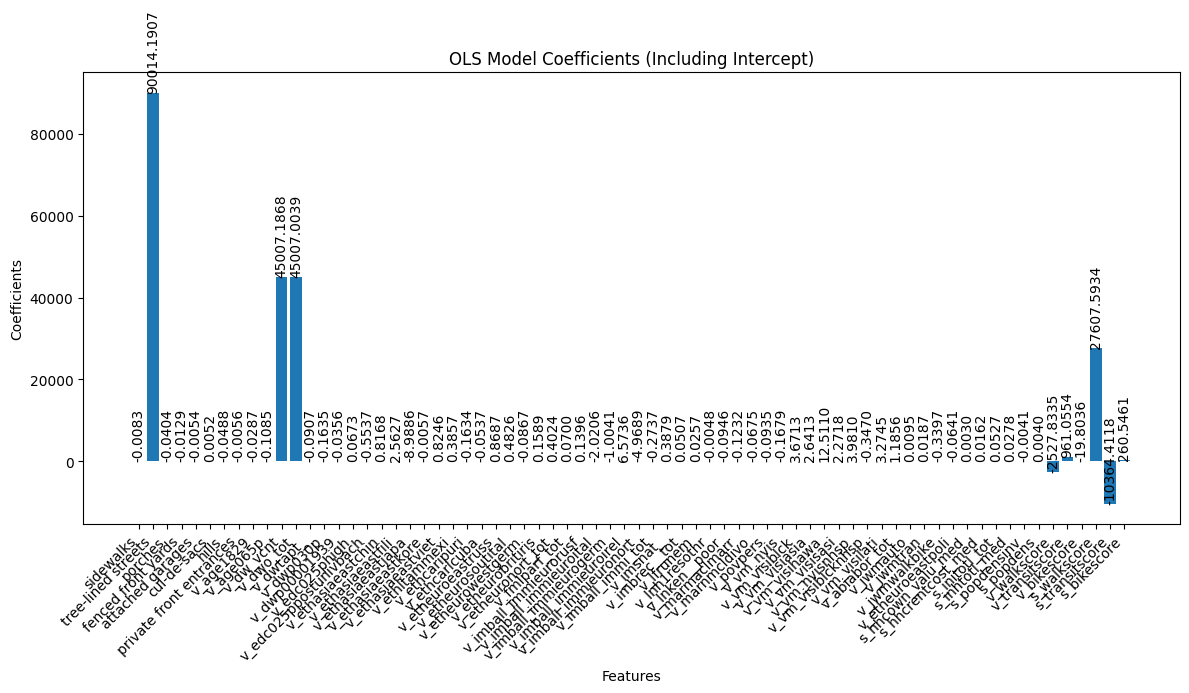

In [ ]:
import matplotlib.pyplot as plt

coefficients = model.params 
features = X_intercept.columns  

plt.figure(figsize=(12, 7))
bars = plt.bar(features, coefficients)

plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('OLS Model Coefficients (Including Intercept)')
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()

C:\Users\Raissa\AppData\Local\Temp\ipykernel_19868\822138680.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[X_intercept.columns.get_loc(feature_name)+1]  # Adjusted index for intercept
C:\Users\Raissa\AppData\Local\Temp\ipykernel_19868\822138680.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_values, model.params[0] + coef * x_values, color='red',


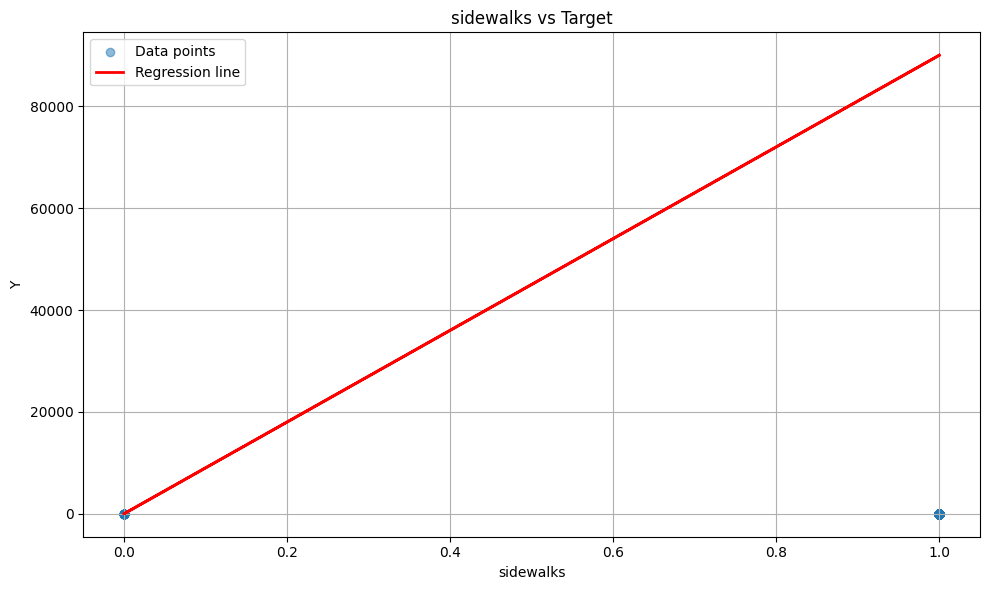

In [ ]:
import matplotlib.pyplot as plt


feature_name = X.columns[0]
x_values = X[feature_name]
coef = model.params[X_intercept.columns.get_loc(feature_name)+1]  


plt.figure(figsize=(10, 6))
plt.scatter(x_values, y, alpha=0.5, label='Data points')
plt.plot(x_values, model.params[0] + coef * x_values, color='red', 
         linewidth=2, label='Regression line')
plt.xlabel(feature_name)
plt.ylabel(y.name if y.name else 'Target Variable')
plt.title(f'{feature_name} vs Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets'] + df['porches'] + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_votes_tract.csv"  
output_csv = "chicago_design_votes_tract.csv"  
process_csv(input_csv, output_csv)

Design Variable

VIF Y2

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     43.32
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          2.86e-159
Time:                        22:53:37   Log-Likelihood:                -626.62
No. Observations:                 760   AIC:                             1331.
Df Residuals:                     721   BIC:                             1512.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

Design Variable
Y

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])



data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = data['Y']


X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     33.70
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          1.28e-168
Time:                        22:54:13   Log-Likelihood:                 784.67
No. Observations:                 760   AIC:                            -1445.
Df Residuals:                     698   BIC:                            -1158.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.371e+

Labels - 100%

In [1]:
import pandas as pd

def group_by_geoid(input_file, output_file):
    df = pd.read_csv(input_file)
    

    aggregated_df = df.groupby('geoid10').sum().reset_index()
    

    aggregated_df = aggregated_df.drop(columns=['id'])
    

    aggregated_df.to_csv(output_file, index=False)
    
input_file = r"C:\Users\Raissa\Documents\dev\TCC\Zero-shot\results_Full_4o_mini_clean.csv"
output_file = "labels_sum_4omini.csv"
group_by_geoid(input_file, output_file)

In [5]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x == 4 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "labels_sum_4omini.csv"
output_file = "labels_100_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_20888\1986225675.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x == 4 else 0)


Labels - 75%

In [6]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 3 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "labels_sum_4omini.csv"
output_file = "labels_75_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_20888\3799201578.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 3 else 0)


In [7]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 2 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "labels_sum_4omini.csv"
output_file = "labels_50_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_20888\4014641801.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 2 else 0)


In [8]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "labels_100_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_labels_100_votes_tract.csv', index=False)

       geoid10  sidewalks  tree-lined streets  porches  fenced front yards  \
0  17031010100          0                   1        0                   0   
1  17031010201          0                   1        0                   0   
2  17031010202          1                   0        0                   1   
3  17031010300          0                   1        0                   1   
4  17031010400          0                   1        1                   1   
5  17031010501          0                   1        0                   1   
6  17031010502          0                   1        1                   1   
7  17031010600          0                   1        0                   0   
8  17031010701          0                   1        1                   1   
9  17031010702          1                   1        0                   1   

   attached garages  cul-de-sacs  hills  private front entrances  \
0                 0            0      0                        0   
1    

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: inv

(760, 45)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     37.53
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          1.23e-155
Time:                        00:09:59   Log-Likelihood:                -623.58
No. Observations:                 760   AIC:                             1337.
Df Residuals:                     715   BIC:                             1546.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

In [11]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "labels_75_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_labels_75_votes_tract.csv', index=False)

       geoid10  sidewalks  tree-lined streets  porches  fenced front yards  \
0  17031010100          0                   1        1                   1   
1  17031010201          1                   1        0                   1   
2  17031010202          1                   0        0                   1   
3  17031010300          0                   1        1                   1   
4  17031010400          1                   1        1                   1   
5  17031010501          0                   1        0                   1   
6  17031010502          1                   1        1                   1   
7  17031010600          1                   1        0                   0   
8  17031010701          0                   1        1                   1   
9  17031010702          1                   1        1                   1   

   attached garages  cul-de-sacs  hills  private front entrances  \
0                 0            0      0                        0   
1    

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: inv

(760, 45)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     37.21
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          9.74e-155
Time:                        00:11:51   Log-Likelihood:                -625.84
No. Observations:                 760   AIC:                             1342.
Df Residuals:                     715   BIC:                             1550.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

In [13]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "labels_50_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_labels_50_votes_tract.csv', index=False)

       geoid10  sidewalks  tree-lined streets  porches  fenced front yards  \
0  17031010100          1                   1        1                   1   
1  17031010201          1                   1        0                   1   
2  17031010202          1                   1        0                   1   
3  17031010300          1                   1        1                   1   
4  17031010400          1                   1        1                   1   
5  17031010501          0                   1        0                   1   
6  17031010502          1                   1        1                   1   
7  17031010600          1                   1        0                   1   
8  17031010701          1                   1        1                   1   
9  17031010702          1                   1        1                   1   

   attached garages  cul-de-sacs  hills  private front entrances  \
0                 0            0      0                        1   
1    

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: inv

(760, 45)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     37.33
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          4.48e-155
Time:                        00:13:28   Log-Likelihood:                -624.99
No. Observations:                 760   AIC:                             1340.
Df Residuals:                     715   BIC:                             1548.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets'] + df['porches'] + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_100_votes_tract.csv"  
output_csv = "chicago_design_100_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.12
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          9.23e-159
Time:                        00:43:17   Log-Likelihood:                -627.88
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

100 design - no porch

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets'] + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_100_votes_tract.csv"  
output_csv = "chicago_design_100_no_porch_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_no_porch_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.13
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          8.74e-159
Time:                        14:58:10   Log-Likelihood:                -627.82
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets'] + df['porches'] + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_75_votes_tract.csv"  
output_csv = "chicago_design_75_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.13
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          8.70e-159
Time:                        00:44:25   Log-Likelihood:                -627.82
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

75 - design wo porch

In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets'] + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_75_votes_tract.csv"  
output_csv = "chicago_design_75_no_porch_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_75_no_porch_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.12
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          9.26e-159
Time:                        15:05:27   Log-Likelihood:                -627.89
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

50% design

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets'] + df['porches'] + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_50_votes_tract.csv"  
output_csv = "chicago_design_50_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.12
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          9.22e-159
Time:                        15:05:09   Log-Likelihood:                -627.88
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

50 - design no porch

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets']  + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_50_votes_tract.csv"  
output_csv = "chicago_design_50_no_porch_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_50_no_porch_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     43.16
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          7.43e-159
Time:                        15:03:55   Log-Likelihood:                -627.65
No. Observations:                 760   AIC:                             1333.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    

    df['design'] = (
        df['sidewalks'] + df['tree-lined streets']  + df['fenced front yards'] -
        df['attached garages'] - df['cul-de-sacs'] - df['hills'] - df['private front entrances']
    )
    

    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_votes_tract.csv"  
output_csv = "chicago_design_votes_no_porch_tract.csv"  
process_csv(input_csv, output_csv)

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_no_porch_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     43.35
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          2.52e-159
Time:                        15:07:49   Log-Likelihood:                -626.48
No. Observations:                 760   AIC:                             1331.
Df Residuals:                     721   BIC:                             1512.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

100 - design pesos

In [26]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    
    # cols = ['sidewalks','tree-lined streets','porches','fenced front yards','attached garages','cul-de-sacs','hills','private front entrances']
    # weights = [0.757,0.943,0.158,0.656,-0.732,-0.571,-1,-0.596]

    df['design'] = (
        (0.757 *df['sidewalks']) + (0.943*df['tree-lined streets']) +  (0.158*df['porches']) + (0.656*df['fenced front yards']) -
        (0.732*df['attached garages']) -(0.571*df['cul-de-sacs']) - df['hills'] - (0.596*df['private front entrances'])
    )
    
    #df['design'] = df[cols].dot(weights)
    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_100_votes_tract.csv"  
output_csv = "chicago_design_100_pesos_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    
    # cols = ['sidewalks','tree-lined streets','porches','fenced front yards','attached garages','cul-de-sacs','hills','private front entrances']
    # weights = [0.757,0.943,0.158,0.656,-0.732,-0.571,-1,-0.596]

    df['design'] = (
        (0.757 *df['sidewalks']) + (0.943*df['tree-lined streets']) +  (0.158*df['porches']) + (0.656*df['fenced front yards']) -
        (0.732*df['attached garages']) -(0.571*df['cul-de-sacs']) - df['hills'] - (0.596*df['private front entrances'])
    )
    
    #df['design'] = df[cols].dot(weights)
    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_75_votes_tract.csv"  
output_csv = "chicago_design_75_pesos_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_csv(input_file, output_file):

    df = pd.read_csv(input_file)
    
    # cols = ['sidewalks','tree-lined streets','porches','fenced front yards','attached garages','cul-de-sacs','hills','private front entrances']
    # weights = [0.757,0.943,0.158,0.656,-0.732,-0.571,-1,-0.596]

    df['design'] = (
        (0.757 *df['sidewalks']) + (0.943*df['tree-lined streets']) +  (0.158*df['porches']) + (0.656*df['fenced front yards']) -
        (0.732*df['attached garages']) -(0.571*df['cul-de-sacs']) - df['hills'] - (0.596*df['private front entrances'])
    )
    
    #df['design'] = df[cols].dot(weights)
    scaler = MinMaxScaler()
    df['design'] = scaler.fit_transform(df[['design']])

    df = df[['tract', 'design', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r', 'Y']]

    df.to_csv(output_file, index=False)


input_csv = "chicago_labels_50_votes_tract.csv"  
output_csv = "chicago_design_50_pesos_votes_tract.csv"  
process_csv(input_csv, output_csv)

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_50_pesos_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.13
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          8.59e-159
Time:                        16:27:15   Log-Likelihood:                -627.80
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_75_pesos_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.12
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          9.25e-159
Time:                        16:27:40   Log-Likelihood:                -627.88
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_pesos_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
y = df_census_normalized['Y2']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     43.12
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          9.26e-159
Time:                        16:28:02   Log-Likelihood:                -627.89
No. Observations:                 760   AIC:                             1334.
Df Residuals:                     721   BIC:                             1514.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

Logistics

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_pesos_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y3'] = (data['n_lightfoot_l_2019r'] > data['n_preckwinkle_t_2019r']).astype(int)
scaler = StandardScaler()
data = data.drop(columns=['tract'])
df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y3'])
y = df_census_normalized['Y3']


X= calculate_vif(X)

print(X.shape)
X = X.loc[y.index]





X_intercept = sm.add_constant(X)


model = sm.GLM(y.values, X_intercept, family=sm.families.Binomial()).fit()  

print(model.summary())

predicted_probs = model.predict(X_intercept)

print(predicted_probs)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(760, 38)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  760
Model:                            GLM   Df Residuals:                      721
Model Family:                Binomial   Df Model:                           38
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 14 Feb 2025   Deviance:                       26113.
Time:                        17:38:19   Pearson chi2:                 3.94e+18
No. Iterations:                     8   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

def calculate_vif(df, threshold=5.0):
   
    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
        # Check if the maximum VIF exceeds the threshold
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the variable with the highest VIF
            drop_var = vif_data.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            #print(f"Dropping '{drop_var}' with VIF: {max_vif}")
            df = df.drop(columns=[drop_var])
        else:
            break

    return df




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)._get_numeric_data().replace([np.inf, -np.inf], np.nan).dropna()

csv_tags_votes = 'chicago_design_100_pesos_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

data = df_tags_census
#data = df_tags_census._get_numeric_data()
#data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y3'] = (data['n_lightfoot_l_2019r'] > data['n_preckwinkle_t_2019r']).astype(int)

data = data.drop(columns=['tract'])
# scaler = StandardScaler()

# df_census_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
#data= calculate_vif(data)
X = data.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y3']) #df_census_normalized.drop(columns=['Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y3'])
y = data['Y3']
print("Unique y values:", np.unique(y))
print("Y value range:", y.min(), y.max())

#X= calculate_vif(X)


X = X.loc[y.index]





X_intercept = sm.add_constant(X)

# Create and fit logistic regression model
model = sm.Logit(y.values, X_intercept).fit(method='bfgs', maxiter=1000)# Added maxiter for convergence

# Print results
print(model.summary())

# Get predicted probabilities
predicted_probs = model.predict(X_intercept)

print(predicted_probs)

Unique y values: [0 1]
Y value range: 0 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 87
         Function evaluations: 93
         Gradient evaluations: 93
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  760
Model:                          Logit   Df Residuals:                      698
Method:                           MLE   Df Model:                           61
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                   1.000
Time:                        17:54:23   Log-Likelihood:            -0.00011046
converged:                       True   LL-Null:                       -61.686
Covariance Type:            nonrobust   LLR p-value:                 4.064e-06
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Sort Var Votes Files

In [2]:
import pandas as pd

def group_by_geoid(input_file, output_file):
    df = pd.read_csv(input_file)
    

    aggregated_df = df.groupby('geoid10').sum().reset_index()
    

    aggregated_df = aggregated_df.drop(columns=['id'])
    

    aggregated_df.to_csv(output_file, index=False)
    
input_file = r"C:\Users\Raissa\Documents\dev\TCC\Zero-shot\results_var_Full_4o_mini_clean.csv"
output_file = "var_sum_4omini.csv"
group_by_geoid(input_file, output_file)

In [3]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x == 4 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "var_sum_4omini.csv"
output_file = "var_100_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_6148\2915262882.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x == 4 else 0)


In [4]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 3 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "var_sum_4omini.csv"
output_file = "var_75_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_6148\3623094237.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 3 else 0)


In [5]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 2 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "var_sum_4omini.csv"
output_file = "var_50_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_6148\400707525.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 2 else 0)


In [6]:
import pandas as pd

def all_positive(input_file, output_file):
    df = pd.read_csv(input_file)
    

    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 1 else 0)


    

    df.to_csv(output_file, index=False)

input_file = "var_sum_4omini.csv"
output_file = "var_25_4omini.csv"
all_positive(input_file, output_file)

C:\Users\Raissa\AppData\Local\Temp\ipykernel_6148\3063272144.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: 1 if x >= 1 else 0)


In [7]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "var_100_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_var_100_votes_tract.csv', index=False)

       geoid10  Yes  n_lightfoot_l_2019r  n_preckwinkle_t_2019r         Y
0  17031010100    0           625.762364             275.016943  0.560509
1  17031010201    1           619.507469             316.140071  0.489691
2  17031010202    1           364.369521             214.951886  0.410072
3  17031010300    1           830.747754             514.151606  0.381098
4  17031010400    1           507.333085             319.181596  0.370864
5  17031010501    0           531.029513             311.658494  0.413105
6  17031010502    1           444.470860             253.101763  0.430555
7  17031010600    1           799.525528             531.700145  0.334980
8  17031010701    1           473.622330             229.078462  0.516327
9  17031010702    1           551.142654             336.981024  0.388577


In [8]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "var_75_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_var_75_votes_tract.csv', index=False)

       geoid10  Yes  n_lightfoot_l_2019r  n_preckwinkle_t_2019r         Y
0  17031010100    1           625.762364             275.016943  0.560509
1  17031010201    1           619.507469             316.140071  0.489691
2  17031010202    1           364.369521             214.951886  0.410072
3  17031010300    1           830.747754             514.151606  0.381098
4  17031010400    1           507.333085             319.181596  0.370864
5  17031010501    0           531.029513             311.658494  0.413105
6  17031010502    1           444.470860             253.101763  0.430555
7  17031010600    1           799.525528             531.700145  0.334980
8  17031010701    1           473.622330             229.078462  0.516327
9  17031010702    1           551.142654             336.981024  0.388577


In [9]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "var_50_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_var_50_votes_tract.csv', index=False)

       geoid10  Yes  n_lightfoot_l_2019r  n_preckwinkle_t_2019r         Y
0  17031010100    1           625.762364             275.016943  0.560509
1  17031010201    1           619.507469             316.140071  0.489691
2  17031010202    1           364.369521             214.951886  0.410072
3  17031010300    1           830.747754             514.151606  0.381098
4  17031010400    1           507.333085             319.181596  0.370864
5  17031010501    1           531.029513             311.658494  0.413105
6  17031010502    1           444.470860             253.101763  0.430555
7  17031010600    1           799.525528             531.700145  0.334980
8  17031010701    1           473.622330             229.078462  0.516327
9  17031010702    1           551.142654             336.981024  0.388577


In [10]:
chicago_votes = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_precincts\mayor2019r.dta'
votes_tracts = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\electoral_tracts\chi_electoral_tracts2010_abs.dta'
census_path = r'C:\Users\Raissa\Documents\dev\TCC\Chicago_City_Data\Chicago Materials\census\chi_census_1970_2017_pct.dta'
labels_file = "var_25_4omini.csv"
aggregated_df = pd.read_csv(labels_file)

df_votes = pd.read_stata(votes_tracts)




df_census = pd.read_stata(census_path)
df_census_2010 = df_census[df_census['year']==2010]
df_votes_tracts = pd.merge(df_votes, df_census_2010[['gjoin2010','tractid10']], 
                     on=['gjoin2010'], how='left')

df_votes_tracts.rename(columns={'tractid10': 'geoid10'}, inplace=True)

aggregated_df_copy = aggregated_df.copy()

df_census.head(3)

aggregated_df_copy.head(3)
df_votes_tracts.head(3)
aggregated_df_copy['geoid10'] =aggregated_df_copy['geoid10'].astype(str)
labels_votes_df = pd.merge(aggregated_df_copy, df_votes_tracts[[ 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r','geoid10']], on=['geoid10'])

def calculate_y(row):
    lightfoot = row['n_lightfoot_l_2019r']
    preckwinkle = row['n_preckwinkle_t_2019r']

    if pd.notna(lightfoot) and pd.notna(preckwinkle):

        diff = lightfoot - preckwinkle
        

        max_diff = max(abs(lightfoot), abs(preckwinkle), 1) 
        y_value = diff / max_diff

        return max(-1, min(y_value, 1))

    return None


labels_votes_df['Y'] = labels_votes_df.apply(calculate_y, axis=1)

print(labels_votes_df.head(10))
labels_votes_df.to_csv('chicago_var_25_votes_tract.csv', index=False)

       geoid10  Yes  n_lightfoot_l_2019r  n_preckwinkle_t_2019r         Y
0  17031010100    1           625.762364             275.016943  0.560509
1  17031010201    1           619.507469             316.140071  0.489691
2  17031010202    1           364.369521             214.951886  0.410072
3  17031010300    1           830.747754             514.151606  0.381098
4  17031010400    1           507.333085             319.181596  0.370864
5  17031010501    1           531.029513             311.658494  0.413105
6  17031010502    1           444.470860             253.101763  0.430555
7  17031010600    1           799.525528             531.700145  0.334980
8  17031010701    1           473.622330             229.078462  0.516327
9  17031010702    1           551.142654             336.981024  0.388577


New VIF - Y2 - 100 - var - Linear

design                   -0.0028      0.002     -1.547      0.122      -0.006       0.0017

In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 46190765408928.164
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113844.59260533842
Removing v_vm_visiblck with VIF = 9154.14622790102
Removing v_vm_visilati with VIF = 422.7482945326947
Removing v_vm_visiasia with VIF = 260.82479056679483
Removing v_vm_nvisnhsp with VIF = 257.6579486629826
Removing v_lnh1resothr with VIF = 52.58182526463707
Removing v_imball_immieuronort with VIF = 37.55065487089474
Removing v_imball_immi_tot with VIF = 34.14378427597493
Removing v_vm_nvis with VIF = 34.13639561059608
Removing v_edc025ppostunivbach with VIF = 33.83450608701869
Removing v_jwmauto with VIF = 29.854923780244015
Removing s_inhtotl_med with VIF = 14.056489910965139
Removing v_fmlparf_tot with VIF = 13.361905323871422
Removing s_initotl_tot with VIF = 11.530481618684773
Removing v_lnken__poor with VIF = 9.533217250812097
Removing

New VIF - Y2 - 75 - var - Linear

design                    0.0019      0.002      1.065      0.287      -0.002       0.005

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45955098238474.445
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113640.56155375385
Removing v_vm_visiblck with VIF = 9138.445798749108
Removing v_vm_visilati with VIF = 423.6610426508225
Removing v_vm_visiasia with VIF = 261.01421811025176
Removing v_vm_nvisnhsp with VIF = 256.96082889335827
Removing v_lnh1resothr with VIF = 52.6096474262363
Removing v_imball_immieuronort with VIF = 37.53816816249242
Removing v_vm_nvis with VIF = 34.214033080454435
Removing v_imball_immi_tot with VIF = 34.16875182660456
Removing v_edc025ppostunivbach with VIF = 33.872421376588974
Removing v_jwmauto with VIF = 29.813517584458243
Removing s_inhtotl_med with VIF = 14.065188044673677
Removing v_fmlparf_tot with VIF = 13.373746683651559
Removing s_initotl_tot with VIF = 11.5219859982579
Removing v_lnken__poor with VIF = 9.561610537442396
Removin

New VIF - Y2 - 50 - var Linear

design                    0.0014      0.002      0.743      0.458      -0.002       0.005

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113886.80038641494
Removing v_vm_visiblck with VIF = 9144.083698987868
Removing v_vm_visilati with VIF = 422.44606997318306
Removing v_vm_visiasia with VIF = 260.8497897996583
Removing v_vm_nvisnhsp with VIF = 256.92665648980227
Removing v_lnh1resothr with VIF = 52.589939719448964
Removing v_imball_immieuronort with VIF = 37.54579769336416
Removing v_imball_immi_tot with VIF = 34.2832522815797
Removing v_edc025ppostunivbach with VIF = 34.109120211215014
Removing v_vm_nvis with VIF = 33.83102389579021
Removing v_jwmauto with VIF = 29.792891239295443
Removing s_inhtotl_med with VIF = 14.136436660371885
Removing v_fmlparf_tot with VIF = 13.366125999722033
Removing s_initotl_tot with VIF = 11.525382602112135
Removing v_lnken__poor with VIF = 9.541353733114832
Removi


New VIF - Y2 - 25 - var - Linear

design                   -0.0007      0.002     -0.397      0.691      -0.004       0.003

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_25_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 114267.52627013896
Removing v_vm_visiblck with VIF = 9155.749260694682
Removing v_vm_visilati with VIF = 422.726078292548
Removing v_vm_visiasia with VIF = 260.8519821272434
Removing v_vm_nvisnhsp with VIF = 256.5963060978325
Removing v_lnh1resothr with VIF = 52.579300499696956
Removing v_imball_immieuronort with VIF = 37.535118734294564
Removing v_imball_immi_tot with VIF = 34.31394179567262
Removing v_edc025ppostunivbach with VIF = 34.11794190838078
Removing v_vm_nvis with VIF = 33.83606516150923
Removing v_jwmauto with VIF = 29.84697980719074
Removing s_inhtotl_med with VIF = 14.323670653813235
Removing v_fmlparf_tot with VIF = 13.368077093236542
Removing s_initotl_tot with VIF = 11.523276796851176
Removing v_lnken__poor with VIF = 9.600132771447772
Removing 

New - Y - 25 - var - Linear

design                   -0.0022      0.004     -0.517      0.605      -0.011       0.006

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_25_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 114267.52627013896
Removing v_vm_visiblck with VIF = 9155.749260694682
Removing v_vm_visilati with VIF = 422.726078292548
Removing v_vm_visiasia with VIF = 260.8519821272434
Removing v_vm_nvisnhsp with VIF = 256.5963060978325
Removing v_lnh1resothr with VIF = 52.579300499696956
Removing v_imball_immieuronort with VIF = 37.535118734294564
Removing v_imball_immi_tot with VIF = 34.31394179567262
Removing v_edc025ppostunivbach with VIF = 34.11794190838078
Removing v_vm_nvis with VIF = 33.83606516150923
Removing v_jwmauto with VIF = 29.84697980719074
Removing s_inhtotl_med with VIF = 14.323670653813235
Removing v_fmlparf_tot with VIF = 13.368077093236542
Removing s_initotl_tot with VIF = 11.523276796851176
Removing v_lnken__poor with VIF = 9.600132771447772
Removing 

New - Y - 50 - var - Linear

design                    0.0036      0.004      0.863      0.388      -0.005       0.012

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113886.80038641494
Removing v_vm_visiblck with VIF = 9144.083698987868
Removing v_vm_visilati with VIF = 422.44606997318306
Removing v_vm_visiasia with VIF = 260.8497897996583
Removing v_vm_nvisnhsp with VIF = 256.92665648980227
Removing v_lnh1resothr with VIF = 52.589939719448964
Removing v_imball_immieuronort with VIF = 37.54579769336416
Removing v_imball_immi_tot with VIF = 34.2832522815797
Removing v_edc025ppostunivbach with VIF = 34.109120211215014
Removing v_vm_nvis with VIF = 33.83102389579021
Removing v_jwmauto with VIF = 29.792891239295443
Removing s_inhtotl_med with VIF = 14.136436660371885
Removing v_fmlparf_tot with VIF = 13.366125999722033
Removing s_initotl_tot with VIF = 11.525382602112135
Removing v_lnken__poor with VIF = 9.541353733114832
Removi

New - Y - 75 - var - Linear

design                    0.0031      0.004      0.767      0.444      -0.005       0.011

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45955098238474.445
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113640.56155375385
Removing v_vm_visiblck with VIF = 9138.445798749108
Removing v_vm_visilati with VIF = 423.6610426508225
Removing v_vm_visiasia with VIF = 261.01421811025176
Removing v_vm_nvisnhsp with VIF = 256.96082889335827
Removing v_lnh1resothr with VIF = 52.6096474262363
Removing v_imball_immieuronort with VIF = 37.53816816249242
Removing v_vm_nvis with VIF = 34.214033080454435
Removing v_imball_immi_tot with VIF = 34.16875182660456
Removing v_edc025ppostunivbach with VIF = 33.872421376588974
Removing v_jwmauto with VIF = 29.813517584458243
Removing s_inhtotl_med with VIF = 14.065188044673677
Removing v_fmlparf_tot with VIF = 13.373746683651559
Removing s_initotl_tot with VIF = 11.5219859982579
Removing v_lnken__poor with VIF = 9.561610537442396
Removin

New - Y - 100 - var - Linear

design                   -0.0070      0.004     -1.705      0.089      -0.015       0.001

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 46190765408928.164
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113844.59260533842
Removing v_vm_visiblck with VIF = 9154.14622790102
Removing v_vm_visilati with VIF = 422.7482945326947
Removing v_vm_visiasia with VIF = 260.82479056679483
Removing v_vm_nvisnhsp with VIF = 257.6579486629826
Removing v_lnh1resothr with VIF = 52.58182526463707
Removing v_imball_immieuronort with VIF = 37.55065487089474
Removing v_imball_immi_tot with VIF = 34.14378427597493
Removing v_vm_nvis with VIF = 34.13639561059608
Removing v_edc025ppostunivbach with VIF = 33.83450608701869
Removing v_jwmauto with VIF = 29.854923780244015
Removing s_inhtotl_med with VIF = 14.056489910965139
Removing v_fmlparf_tot with VIF = 13.361905323871422
Removing s_initotl_tot with VIF = 11.530481618684773
Removing v_lnken__poor with VIF = 9.533217250812097
Removing

New VIF - Y3 - 100 - var - Logistics

design                    0.0015      0.117      0.013      0.990      -0.227       0.230

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.183920e+00
1        v_age1829  5.971174e+00
2        v_age065p  4.038040e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.619077e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.619077e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 46190765408928.164
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113844.59260533842
Removing v_vm_visiblck with VIF = 9154.14622790102
Removing v_vm_visilati with VIF = 422.7482945326947
Removing v_vm_visiasia with VIF = 260.82479056679483
Removing v_vm_nvisnhsp with VIF = 257.6579486629826
Removing v_lnh1resothr with VIF = 52.58182526463707
Removing v_imball_immieuronort with VIF = 37.55065487089474
Removing v_imball_immi_tot with VIF = 34.14378427597493
Removing v_vm_nvis with VIF = 34.13639561059608
Removing v_edc025ppostunivbach with VIF = 33.83450608701869
Removing v_jwmauto with VIF = 29.854923780244015
Removing s_inhtotl_med with VIF = 14.056489910965139
Removing v_fmlparf_tot with VIF = 13.361905323871422
Removing s_initotl_tot with VIF = 11.530481618684773
Removing v_lnken__poor with VIF = 9.533217250812097
Removing

New VIF - Y3 - 75 - var - Logistics

design                    0.0771      0.109      0.707      0.479      -0.137       0.291

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.147778e+00
1        v_age1829  5.968580e+00
2        v_age065p  4.037753e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45955098238474.445
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113640.56155375385
Removing v_vm_visiblck with VIF = 9138.445798749108
Removing v_vm_visilati with VIF = 423.6610426508225
Removing v_vm_visiasia with VIF = 261.01421811025176
Removing v_vm_nvisnhsp with VIF = 256.96082889335827
Removing v_lnh1resothr with VIF = 52.6096474262363
Removing v_imball_immieuronort with VIF = 37.53816816249242
Removing v_vm_nvis with VIF = 34.214033080454435
Removing v_imball_immi_tot with VIF = 34.16875182660456
Removing v_edc025ppostunivbach with VIF = 33.872421376588974
Removing v_jwmauto with VIF = 29.813517584458243
Removing s_inhtotl_med with VIF = 14.065188044673677
Removing v_fmlparf_tot with VIF = 13.373746683651559
Removing s_initotl_tot with VIF = 11.5219859982579
Removing v_lnken__poor with VIF = 9.561610537442396
Removin

New VIF - Y3 - 50 - var Logistics

design                   -0.2494      0.173     -1.441      0.150      -0.589       0.090

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.185797e+00
1        v_age1829  5.970212e+00
2        v_age065p  4.039193e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113886.80038641494
Removing v_vm_visiblck with VIF = 9144.083698987868
Removing v_vm_visilati with VIF = 422.44606997318306
Removing v_vm_visiasia with VIF = 260.8497897996583
Removing v_vm_nvisnhsp with VIF = 256.92665648980227
Removing v_lnh1resothr with VIF = 52.589939719448964
Removing v_imball_immieuronort with VIF = 37.54579769336416
Removing v_imball_immi_tot with VIF = 34.2832522815797
Removing v_edc025ppostunivbach with VIF = 34.109120211215014
Removing v_vm_nvis with VIF = 33.83102389579021
Removing v_jwmauto with VIF = 29.792891239295443
Removing s_inhtotl_med with VIF = 14.136436660371885
Removing v_fmlparf_tot with VIF = 13.366125999722033
Removing s_initotl_tot with VIF = 11.525382602112135
Removing v_lnken__poor with VIF = 9.541353733114832
Removi

New VIF - Y3 - 25 - var - Logistics

design                   -0.0109      0.110     -0.099      0.921      -0.226       0.204

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_var_25_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.286817e+00
1        v_age1829  6.051719e+00
2        v_age065p  4.040683e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 114267.52627013896
Removing v_vm_visiblck with VIF = 9155.749260694682
Removing v_vm_visilati with VIF = 422.726078292548
Removing v_vm_visiasia with VIF = 260.8519821272434
Removing v_vm_nvisnhsp with VIF = 256.5963060978325
Removing v_lnh1resothr with VIF = 52.579300499696956
Removing v_imball_immieuronort with VIF = 37.535118734294564
Removing v_imball_immi_tot with VIF = 34.31394179567262
Removing v_edc025ppostunivbach with VIF = 34.11794190838078
Removing v_vm_nvis with VIF = 33.83606516150923
Removing v_jwmauto with VIF = 29.84697980719074
Removing s_inhtotl_med with VIF = 14.323670653813235
Removing v_fmlparf_tot with VIF = 13.368077093236542
Removing s_initotl_tot with VIF = 11.523276796851176
Removing v_lnken__poor with VIF = 9.600132771447772
Removing 

New VIF Y2 100 design - Linear

design                 -0.0002      0.002     -0.095      0.925      -0.004       0.003

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113636.09497524264
Removing v_vm_visiblck with VIF = 9137.679748153932
Removing v_vm_visilati with VIF = 421.98339136594564
Removing v_vm_visiasia with VIF = 261.88399832320755
Removing v_vm_nvisnhsp with VIF = 256.44830419087344
Removing v_lnh1resothr with VIF = 52.78492394423932
Removing v_imball_immieuronort with VIF = 37.5383529756333
Removing v_imball_immi_tot with VIF = 34.170539891863946
Removing v_edc025ppostunivbach with VIF = 34.09110533529132
Removing v_vm_nvis with VIF = 33.82675927547623
Removing v_jwmauto with VIF = 29.82749464799209
Removing s_inhtotl_med with VIF = 14.094321374283242
Removing v_fmlparf_tot with VIF = 13.392298157782637
Removing s_initotl_tot with VIF = 11.529154732619675
Removing v_lnken__poor with VIF = 9.605688607497859
Removin

New VIF Y2 75 design - Linear

design                    0.0006      0.002      0.361      0.718      -0.003       0.004

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 46190765408928.164
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113950.79716187881
Removing v_vm_visiblck with VIF = 9151.012121166159
Removing v_vm_visilati with VIF = 422.719367497659
Removing v_vm_visiasia with VIF = 261.3809369511939
Removing v_vm_nvisnhsp with VIF = 256.5076829157499
Removing v_lnh1resothr with VIF = 52.78984862764565
Removing v_imball_immieuronort with VIF = 37.534976394274366
Removing v_imball_immi_tot with VIF = 34.130893554269626
Removing v_edc025ppostunivbach with VIF = 34.089716462147216
Removing v_vm_nvis with VIF = 33.799432517424734
Removing v_jwmauto with VIF = 29.88090259220191
Removing s_inhtotl_med with VIF = 14.065227262246369
Removing v_fmlparf_tot with VIF = 13.379591992061258
Removing s_initotl_tot with VIF = 11.537735991681389
Removing v_lnken__poor with VIF = 9.528193428076403
Removi

New VIF Y2 50 design - Linear

design -0.0002      0.002     -0.108      0.914      -0.004       0.003

In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45955098238474.445
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 114006.6757971776
Removing v_vm_visiblck with VIF = 9138.562460279642
Removing v_vm_visilati with VIF = 422.1341953908372
Removing v_vm_visiasia with VIF = 260.91208549627356
Removing v_vm_nvisnhsp with VIF = 257.0162261029194
Removing v_lnh1resothr with VIF = 52.60969466120296
Removing v_imball_immieuronort with VIF = 37.537598000095954
Removing v_vm_nvis with VIF = 34.2243167975597
Removing v_imball_immi_tot with VIF = 34.16444487178249
Removing v_edc025ppostunivbach with VIF = 33.92167096424
Removing v_jwmauto with VIF = 29.79135758127695
Removing s_inhtotl_med with VIF = 14.083437560162196
Removing v_fmlparf_tot with VIF = 13.361848660104501
Removing s_initotl_tot with VIF = 11.52169700908147
Removing v_lnken__poor with VIF = 9.525539532396673
Removing v_ed

New VIF Y2 25 design - Linear

design 0.0028      0.002      1.552      0.121      -0.001       0.006

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

New VIF Y 25 design - Linear

design                    0.0035      0.004      0.860      0.390      -0.004       0.011

In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

New VIF Y 50 design - Linear

design                   -0.0007      0.004     -0.170      0.865      -0.009       0.007

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45955098238474.445
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 114006.6757971776
Removing v_vm_visiblck with VIF = 9138.562460279642
Removing v_vm_visilati with VIF = 422.1341953908372
Removing v_vm_visiasia with VIF = 260.91208549627356
Removing v_vm_nvisnhsp with VIF = 257.0162261029194
Removing v_lnh1resothr with VIF = 52.60969466120296
Removing v_imball_immieuronort with VIF = 37.537598000095954
Removing v_vm_nvis with VIF = 34.2243167975597
Removing v_imball_immi_tot with VIF = 34.16444487178249
Removing v_edc025ppostunivbach with VIF = 33.92167096424
Removing v_jwmauto with VIF = 29.79135758127695
Removing s_inhtotl_med with VIF = 14.083437560162196
Removing v_fmlparf_tot with VIF = 13.361848660104501
Removing s_initotl_tot with VIF = 11.52169700908147
Removing v_lnken__poor with VIF = 9.525539532396673
Removing v_ed

New VIF Y 75 design - Linear

design                    0.0019      0.004      0.482      0.630      -0.006       0.010



In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 46190765408928.164
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113950.79716187881
Removing v_vm_visiblck with VIF = 9151.012121166159
Removing v_vm_visilati with VIF = 422.719367497659
Removing v_vm_visiasia with VIF = 261.3809369511939
Removing v_vm_nvisnhsp with VIF = 256.5076829157499
Removing v_lnh1resothr with VIF = 52.78984862764565
Removing v_imball_immieuronort with VIF = 37.534976394274366
Removing v_imball_immi_tot with VIF = 34.130893554269626
Removing v_edc025ppostunivbach with VIF = 34.089716462147216
Removing v_vm_nvis with VIF = 33.799432517424734
Removing v_jwmauto with VIF = 29.88090259220191
Removing s_inhtotl_med with VIF = 14.065227262246369
Removing v_fmlparf_tot with VIF = 13.379591992061258
Removing s_initotl_tot with VIF = 11.537735991681389
Removing v_lnken__poor with VIF = 9.528193428076403
Removi

New VIF Y 100 design - Linear

design                   -0.0003      0.004     -0.079      0.937      -0.008       0.008

In [40]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113636.09497524264
Removing v_vm_visiblck with VIF = 9137.679748153932
Removing v_vm_visilati with VIF = 421.98339136594564
Removing v_vm_visiasia with VIF = 261.88399832320755
Removing v_vm_nvisnhsp with VIF = 256.44830419087344
Removing v_lnh1resothr with VIF = 52.78492394423932
Removing v_imball_immieuronort with VIF = 37.5383529756333
Removing v_imball_immi_tot with VIF = 34.170539891863946
Removing v_edc025ppostunivbach with VIF = 34.09110533529132
Removing v_vm_nvis with VIF = 33.82675927547623
Removing v_jwmauto with VIF = 29.82749464799209
Removing s_inhtotl_med with VIF = 14.094321374283242
Removing v_fmlparf_tot with VIF = 13.392298157782637
Removing s_initotl_tot with VIF = 11.529154732619675
Removing v_lnken__poor with VIF = 9.605688607497859
Removin

New VIF - Y3 - 100 - design - Logistics

design                   -0.1920      0.150     -1.280      0.201      -0.486       0.102

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.124659e+00
1        v_age1829  5.959140e+00
2        v_age065p  4.040933e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113636.09497524264
Removing v_vm_visiblck with VIF = 9137.679748153932
Removing v_vm_visilati with VIF = 421.98339136594564
Removing v_vm_visiasia with VIF = 261.88399832320755
Removing v_vm_nvisnhsp with VIF = 256.44830419087344
Removing v_lnh1resothr with VIF = 52.78492394423932
Removing v_imball_immieuronort with VIF = 37.5383529756333
Removing v_imball_immi_tot with VIF = 34.170539891863946
Removing v_edc025ppostunivbach with VIF = 34.09110533529132
Removing v_vm_nvis with VIF = 33.82675927547623
Removing v_jwmauto with VIF = 29.82749464799209
Removing s_inhtotl_med with VIF = 14.094321374283242
Removing v_fmlparf_tot with VIF = 13.392298157782637
Removing s_initotl_tot with VIF = 11.529154732619675
Removing v_lnken__poor with VIF = 9.605688607497859
Removin

New VIF - Y3 - 75 - design - Logistics

design                    0.0230      0.117      0.197      0.844      -0.206       0.253

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.136775e+00
1        v_age1829  5.961560e+00
2        v_age065p  4.037989e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.619077e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.619077e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 46190765408928.164
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 113950.79716187881
Removing v_vm_visiblck with VIF = 9151.012121166159
Removing v_vm_visilati with VIF = 422.719367497659
Removing v_vm_visiasia with VIF = 261.3809369511939
Removing v_vm_nvisnhsp with VIF = 256.5076829157499
Removing v_lnh1resothr with VIF = 52.78984862764565
Removing v_imball_immieuronort with VIF = 37.534976394274366
Removing v_imball_immi_tot with VIF = 34.130893554269626
Removing v_edc025ppostunivbach with VIF = 34.089716462147216
Removing v_vm_nvis with VIF = 33.799432517424734
Removing v_jwmauto with VIF = 29.88090259220191
Removing s_inhtotl_med with VIF = 14.065227262246369
Removing v_fmlparf_tot with VIF = 13.379591992061258
Removing s_initotl_tot with VIF = 11.537735991681389
Removing v_lnken__poor with VIF = 9.528193428076403
Removi

New VIF - Y3 - 50 - design - Logistics

design                    0.0863      0.116      0.745      0.456      -0.141       0.313

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_50_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.114867e+00
1        v_age1829  5.967133e+00
2        v_age065p  4.041411e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.617349e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45955098238474.445
Removing v_walkscore with VIF = 36173490982895.55
Removing v_vm_visiblcknhsp with VIF = 114006.6757971776
Removing v_vm_visiblck with VIF = 9138.562460279642
Removing v_vm_visilati with VIF = 422.1341953908372
Removing v_vm_visiasia with VIF = 260.91208549627356
Removing v_vm_nvisnhsp with VIF = 257.0162261029194
Removing v_lnh1resothr with VIF = 52.60969466120296
Removing v_imball_immieuronort with VIF = 37.537598000095954
Removing v_vm_nvis with VIF = 34.2243167975597
Removing v_imball_immi_tot with VIF = 34.16444487178249
Removing v_edc025ppostunivbach with VIF = 33.92167096424
Removing v_jwmauto with VIF = 29.79135758127695
Removing s_inhtotl_med with VIF = 14.083437560162196
Removing v_fmlparf_tot with VIF = 13.361848660104501
Removing s_initotl_tot with VIF = 11.52169700908147
Removing v_lnken__poor with VIF = 9.525539532396673
Removing v_ed

New VIF - Y3 - 25 - design - Logistics

design                    0.2771      0.120      2.317      0.020       0.043       0.511

y > 0.65
design                    0.5089      0.152      3.347      0.001       0.211       0.807

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

z = data['Y'].abs()
# Binarize the target variable `Y`
y = (z > 0.65).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.137915e+00
1        v_age1829  5.961426e+00
2        v_age065p  4.050292e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.631935e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

New VIF Y2 25 labels - Linear

sidewalks                  -0.0008      0.002     -0.461      0.645      -0.004       0.003

tree-lined streets       1.042e-17   3.84e-18      2.711      0.007    2.87e-18     1.8e-17

porches                     0.0006      0.002      0.296      0.767      -0.004       0.005

fenced front yards          0.0004      0.002      0.223      0.824      -0.003       0.004

attached garages           -0.0031      0.002     -1.740      0.082      -0.007       0.000

cul-de-sacs                -0.0004      0.002     -0.246      0.806      -0.004       0.003

hills                      -0.0016      0.002     -0.893      0.372      -0.005       0.002

private front entrances    -0.0022      0.002     -1.095      0.274      -0.006       0.002


In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 56294995342131.2


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_transitscore with VIF = 46912496118442.664


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_walkscore with VIF = 36614631116833.305


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblcknhsp with VIF = 114122.09753111623


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblck with VIF = 9141.481975293658


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visilati with VIF = 424.96108848318835


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiasia with VIF = 264.83027245244534


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvisnhsp with VIF = 258.63884839024183


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnh1resothr with VIF = 53.71277460225765


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immieuronort with VIF = 37.75867583895965


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvis with VIF = 34.728759089872575


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immi_tot with VIF = 34.42323607064788


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025ppostunivbach with VIF = 34.20810336966395


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_jwmauto with VIF = 30.227636999477337


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_inhtotl_med with VIF = 14.164913821212545


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_fmlparf_tot with VIF = 13.467234027922478


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_initotl_tot with VIF = 11.655904460812659


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnken__poor with VIF = 9.569422573443676


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025phigh with VIF = 7.436572453670482


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_walkscore with VIF = 6.792567507344841


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_marmaclmarr with VIF = 6.27483446496305


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_etheurowestgerm with VIF = 5.48062885601553


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imsnat_ with VIF = 5.205496084591912


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     37.32
Date:                Sun, 16 Feb 2025   Prob (F-statistic):          5.01e-155
Time:                        16:05:25   Log-Likelihood:                 1271.7
No. Observations:                 760   AIC:                            -2453.
Df Residuals:                     715   BIC:                            -2245.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

New VIF Y2 100 labels - Linear

In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_bikescore with VIF = 55599995399635.75


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_transitscore with VIF = 46190765408928.164


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_walkscore with VIF = 36319351833633.03


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblcknhsp with VIF = 113878.61113048029


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblck with VIF = 9207.916928899233


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visilati with VIF = 423.98166656305125


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiasia with VIF = 265.2186170836005


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvisnhsp with VIF = 260.5415315495518


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnh1resothr with VIF = 53.192195334879514


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immieuronort with VIF = 37.58394813515062


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immi_tot with VIF = 34.64854293075523


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvis with VIF = 34.29194953921219


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025ppostunivbach with VIF = 33.92986800255849


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_jwmauto with VIF = 30.23578013888855


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_inhtotl_med with VIF = 14.131382227242712


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_fmlparf_tot with VIF = 13.429092305018619


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_initotl_tot with VIF = 11.662986606593508


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnken__poor with VIF = 9.666189672440256


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025phigh with VIF = 7.4396846447139


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_walkscore with VIF = 6.765460263517416


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_marmaclmarr with VIF = 6.336220692398945


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_etheurowestgerm with VIF = 5.513937956765563


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imsnat_ with VIF = 5.19231775977501


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     37.53
Date:                Sun, 16 Feb 2025   Prob (F-statistic):          1.23e-155
Time:                        17:14:41   Log-Likelihood:                 1273.2
No. Observations:                 760   AIC:                            -2456.
Df Residuals:                     715   BIC:                            -2248.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.6).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.137915e+00
1        v_age1829  5.961426e+00
2        v_age065p  4.050292e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.631935e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.65).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.137915e+00
1        v_age1829  5.961426e+00
2        v_age065p  4.050292e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.631935e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_75_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Binarize the target variable `Y`
y = (data['Y'] > 0.65).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'fenced font yards'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)
    print(logit_model.coef_)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
               Feature           VIF
0            sidewalks  1.137808e+00
1   tree-lined streets  1.238754e+00
2              porches  1.253376e+00
3   fenced front yards  1.236445e+00
4     attached garages  1.146854e+00
..                 ...           ...
65      v_transitscore  4.642886e+13
66         v_bikescore  5.594534e+13
67         s_walkscore  3.646639e+13
68      s_transitscore  4.642886e+13
69         s_bikescore  5.594534e+13

[70 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_bikescore with VIF = 55945336985968.89


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_transitscore with VIF = 46428862137840.164


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_walkscore with VIF = 36466393743890.66


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblcknhsp with VIF = 115044.53904273397


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblck with VIF = 9202.933510035577


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visilati with VIF = 425.1712741661242


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiasia with VIF = 262.37559028027687


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvisnhsp with VIF = 258.5467651286513


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnh1resothr with VIF = 53.57309804114403


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immieuronort with VIF = 37.82417858362405


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immi_tot with VIF = 34.463631995077044


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025ppostunivbach with VIF = 34.31219847908814


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvis with VIF = 33.90252137388588


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_jwmauto with VIF = 29.984891924114482


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_inhtotl_med with VIF = 14.126826852169422


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_fmlparf_tot with VIF = 13.514925463134459


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_initotl_tot with VIF = 11.645724293085577


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnken__poor with VIF = 9.673831524674856


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025phigh with VIF = 7.449779894269881


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_walkscore with VIF = 6.78082343056358


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_marmaclmarr with VIF = 6.348285961258058


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_etheurowestgerm with VIF = 5.527420144476395


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imsnat_ with VIF = 5.180305215640029


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Optimization terminated successfully.
         Current function value: 0.266994
         Iterations 8
Error fitting logistic regression model: Singular matrix
Falling back to scikit-learn LogisticRegression with L2 regularization.
[[ 1.25092967e-01 -1.00286620e-01  1.59679300e-01  2.41688670e-02
   1.57136206e-01 -9.91697822e-02  0.00000000e+00 -2.72459241e-02
   1.38989355e-01 -1.66533913e-02 -6.53193014e-02 -1.05270657e-01
  -4.28623353e-01 -2.60815055e-01  1.41726142e-01  2.25030749e-01
  -6.23093182e-01  5.76094667e-02 -2.08971769e-02  1.14625695e+00
   1.07313063e-03 -9.90222055e-02  5.74741415e-01  5.67449657e-01
   8.58250173e-01  1.81138288e-01  5.17416305e-02  2.07980539e-01
   2.53545474e-01  4.75687442e-01 -8.61316423e-02  2.65472300e-01
  -4.37055031e-01 -2.06449099e-01  1.27978518e-01  3.29388444e-03
  -2.65857759e-01 -3.73735979e-01 -1.96304140e-01  1.19580316e+00
   3.40520389e-01  5.01339962e-01  1.70066036e-04  2.19519970e-02
  -9.94077861e-01]]


In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_labels_100_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

data['Y2'] = (data['n_lightfoot_l_2019r'] / (data['n_lightfoot_l_2019r'] + data['n_preckwinkle_t_2019r'])) 
y = data['Y2'] 
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r','Y2'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_bikescore with VIF = 55599995399635.75


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_transitscore with VIF = 46190765408928.164


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_walkscore with VIF = 36319351833633.03


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblcknhsp with VIF = 113878.61113048029


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiblck with VIF = 9207.916928899233


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visilati with VIF = 423.98166656305125


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_visiasia with VIF = 265.2186170836005


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvisnhsp with VIF = 260.5415315495518


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnh1resothr with VIF = 53.192195334879514


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immieuronort with VIF = 37.58394813515062


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imball_immi_tot with VIF = 34.64854293075523


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_vm_nvis with VIF = 34.29194953921219


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025ppostunivbach with VIF = 33.92986800255849


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_jwmauto with VIF = 30.23578013888855


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_inhtotl_med with VIF = 14.131382227242712


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_fmlparf_tot with VIF = 13.429092305018619


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_initotl_tot with VIF = 11.662986606593508


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_lnken__poor with VIF = 9.666189672440256


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_edc025phigh with VIF = 7.4396846447139


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing s_walkscore with VIF = 6.765460263517416


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_marmaclmarr with VIF = 6.336220692398945


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_etheurowestgerm with VIF = 5.513937956765563


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing v_imsnat_ with VIF = 5.19231775977501


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     37.53
Date:                Sun, 16 Feb 2025   Prob (F-statistic):          1.23e-155
Time:                        15:48:35   Log-Likelihood:                 1273.2
No. Observations:                 760   AIC:                            -2456.
Df Residuals:                     715   BIC:                            -2248.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.137915e+00
1        v_age1829  5.961426e+00
2        v_age065p  4.050292e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.631935e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

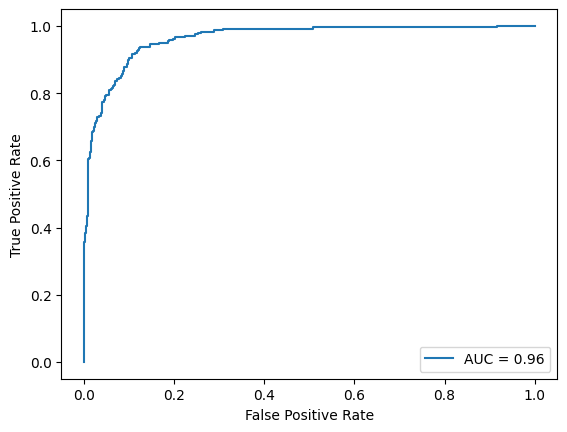

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()
k = 0.7
# Binarize the target variable `Y`
y = (data['Y'] > k).astype(int)  # Convert to binary (0 or 1)

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)  # Preserve index

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)



# Ensure X and y have the same index
common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)

# Fit logistic regression model using statsmodels
try:
    logit_model = sm.Logit(y, X_intercept).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting logistic regression model: {e}")
    print("Falling back to scikit-learn LogisticRegression with L2 regularization.")

    # Use scikit-learn LogisticRegression as a fallback
    logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    logit_model.fit(X, y)



#######################3

from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    confusion_matrix,
)
import matplotlib.pyplot as plt

# Generate predicted probabilities
predicted_probs = logit_model.predict(X_intercept)


# Convert probabilities to predicted classes (using a threshold of 0.6)
predicted_classes = (predicted_probs > k).astype(int)

# Compute AUC
auc = roc_auc_score(y, predicted_probs)
print(f"AUC: {auc:.4f}")

# Compute recall, precision, and F1-score
recall = recall_score(y, predicted_classes)
precision = precision_score(y, predicted_classes)
f1 = f1_score(y, predicted_classes)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y, predicted_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
plt.legend()
plt.show()

-0.2662102828928804
0.9446989662374712
454
520
604
tract                    8.856348e+12
design                   2.537500e+02
n_lightfoot_l_2019r      2.183334e+05
n_preckwinkle_t_2019r    1.002567e+05
Y                        2.755866e+02
                             ...     
v_transitscore           3.397297e+04
v_bikescore              3.748785e+04
s_walkscore             -1.668868e+01
s_transitscore           1.545509e+01
s_bikescore              1.775749e+01
Length: 67, dtype: float64
0.4864583333333333
0.4950980392156863
0.4855769230769231
732
0.5
720
0.5
700
0.5
671
0.5
623
0.5
524
0.5
407
0.5
306
0.5
240
0.5
156
0.5
85
0.5
27
0.5
7
0.5
       k  design_means  design_medians  design_std_devs
0   0.30      0.484631             0.5         0.164951
1   0.35      0.485069             0.5         0.164799
2   0.40      0.484643             0.5         0.165507
3   0.45      0.484352             0.5         0.165429
4   0.50      0.483949             0.5         0.165756
5   0.55   

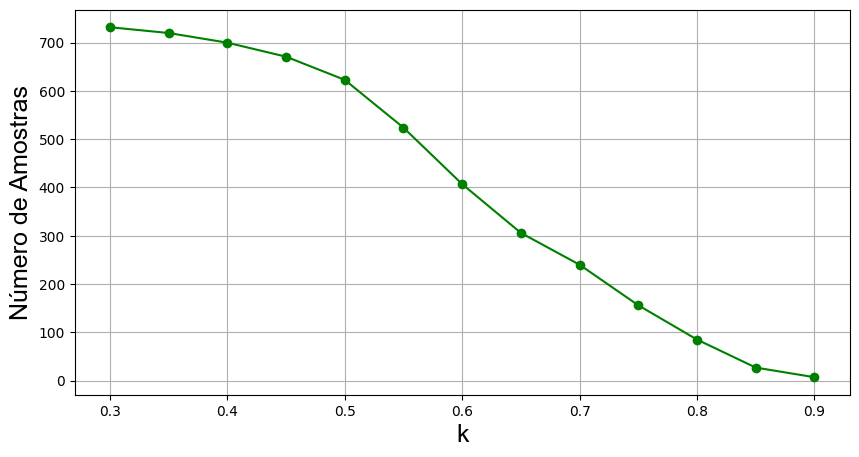

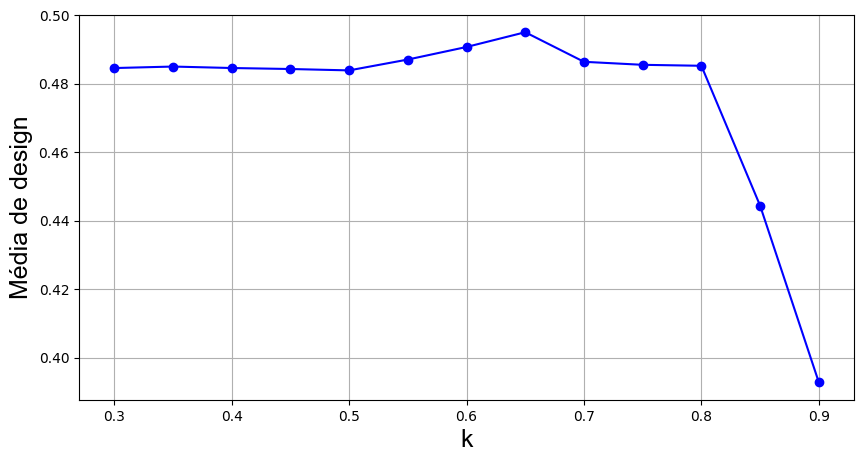

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import matplotlib.pyplot as plt
# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

print(data['Y'].min())
print(data['Y'].max())
print((data['Y']<0.65).sum())


print((data['Y']<0.7).sum())
print((data['Y']<0.75).sum())

print((data[data['Y']<0.7]).sum())
x = data[data['Y']>0.7]
print(x['design'].mean())

z = data[data['Y']>0.65]
print(z['design'].mean())

w = data[data['Y']>0.75]
print(w['design'].mean())


n_samples = []
design_means = []
design_medians = []
design_std_devs = []

k_values = np.arange(0.3, 0.95, 0.05)

for k in k_values:
    y = data[data['Y'] > k]['Y']
    n_samples.append(len(y))
    print(len(y))
    print(data[data['Y'] > k]['design'].median())
    design_means.append(data[data['Y'] > k]['design'].mean())
    design_medians.append(data[data['Y'] > k]['design'].median())
    design_std_devs.append(data[data['Y'] > k]['design'].std())

results_df = pd.DataFrame({
    'k': k_values,
    'design_means': design_means,
    'design_medians': design_medians,
    'design_std_devs': design_std_devs
})
print(results_df)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.figure(figsize=(10, 5))
plt.plot(k_values, n_samples, marker='o', label='Número de amostras', color='green')
plt.xlabel('k',**axis_font)
plt.ylabel('Número de Amostras',**axis_font)
#plt.title('Amostras vs  k')
plt.grid()
#plt.legend()
plt.show()

# Plot Design Mean and Median vs k
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, design_means, marker='o', label='Mean of Design', color='purple')
# plt.plot(k_values, design_medians, marker='s', label='Median of Design', color='orange')
# plt.xlabel('k')
# plt.ylabel('')
# plt.title('Media e mediana vs  k')
# plt.grid()
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, design_means, marker='o', label='Média de design', color='blue')
#plt.plot(k_values, design_medians, marker='s', label='Median Design', color='orange')
#plt.fill_between(k_values, np.array(design_means) - np.array(design_std_devs), np.array(design_means) + np.array(design_std_devs), color='blue', alpha=0.2, label='Dev Padrão')
#plt.bar(k_values, design_std_devs, color='gray', alpha=0.5, label='Std Dev')
plt.xlabel('k',**axis_font)
plt.ylabel('Média de design',**axis_font)
#plt.title('Media vs  k')
plt.grid()
#plt.legend()
plt.show()


In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data




census_path =  'census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)


df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])


data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

y = data['Y'].abs()
scaler = StandardScaler()

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)



feature_to_preserve = 'design'

vif_df = calculate_vif(X)

threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

common_index = X.index.intersection(y.index)  # Find common indices
X = X.loc[common_index]
y = y.loc[common_index]

# Add intercept for logistic regression
X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

DEM

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import statsmodels.api as sm

import pandas as pd

census_path =  './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])



data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

k = 0
#filter results -- keeping only very defined cases
data = data[data['Y']>k ]

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = data['Y']



scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.Series(scaler.fit_transform(y.values.reshape(-1, 1)).flatten(), name='Y')







# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

#print("\nVIF after removing multicollinear features:")
#print(vif_df)
#print("\nFinal dataset:")
#print(X)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.141787e+00
1        v_age1829  5.916421e+00
2        v_age065p  4.085233e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.666943e+13
59     v_bikescore  5.492195e+13
60     s_walkscore  3.676408e+13
61  s_transitscore  4.666943e+13
62     s_bikescore  5.492195e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 54921946675249.95
Removing v_transitscore with VIF = 46669426190367.836
Removing v_walkscore with VIF = 36764078590779.56
Removing v_vm_visiblcknhsp with VIF = 115988.38129382966
Removing v_vm_visiblck with VIF = 9600.531176614673
Removing v_vm_visilati with VIF = 421.08374948325303
Removing v_vm_nvisnhsp with VIF = 262.0663450864581
Removing v_vm_visiasia with VIF = 261.1189808348387
Removing v_lnh1resothr with VIF = 53.29879794831547
Removing v_imball_immieuronort with VIF = 37.35501790077968
Removing v_vm_nvis with VIF = 35.4353540585422
Removing v_imball_immi_tot with VIF = 34.270855037311904
Removing v_edc025ppostunivbach with VIF = 33.86162208310559
Removing v_jwmauto with VIF = 28.994058404889774
Removing s_inhtotl_med with VIF = 14.822385640832382
Removing v_fmlparf_tot with VIF = 13.66695643229163
Removing s_initotl_tot with VIF = 11.804918858760294
Removing v_lnken__poor with VIF = 9.624509258330349
Removing

REP

In [4]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import statsmodels.api as sm

import pandas as pd

census_path =  './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])



data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()


#filter results -- keeping only very defined cases
data = data[data['Y']<0 ]

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = data['Y']



scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.Series(scaler.fit_transform(y.values.reshape(-1, 1)).flatten(), name='Y')







# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

#print("\nVIF after removing multicollinear features:")
#print(vif_df)
#print("\nFinal dataset:")
#print(X)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encoun

VIF before removing multicollinear features:
           Feature           VIF
0           design  1.096209e+05
1        v_age1829  1.891811e+05
2        v_age065p  7.486199e+04
3        v_dw_vcnt  4.168789e+05
4        v_dwo_tot  1.109536e+04
..             ...           ...
58  v_transitscore  3.623860e+05
59     v_bikescore           inf
60     s_walkscore  3.919560e+04
61  s_transitscore  2.143623e+05
62     s_bikescore  8.962829e+04

[63 rows x 2 columns]
Removing v_bikescore with VIF = inf
Preserving design and removing v_age1829 with VIF = inf
Preserving design and removing v_age065p with VIF = inf
Preserving design and removing v_dw_vcnt with VIF = inf
Preserving design and removing v_dwo_tot with VIF = inf
Preserving design and removing v_dwtapt_ with VIF = inf
Preserving design and removing v_dwp030p with VIF = inf
Preserving design and removing v_dwp00001939 with VIF = inf
Preserving design and removing v_edc025phigh with VIF = inf
Preserving design and removing v_edc025ppost

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encoun

Preserving design and removing v_imbrec__tot with VIF = inf
Preserving design and removing v_lfrunem with VIF = inf
Preserving design and removing v_lnh1resothr with VIF = inf
Preserving design and removing v_lnken__poor with VIF = inf
Preserving design and removing v_marmaclmarr with VIF = inf
Preserving design and removing v_marnmcldivo with VIF = inf
Preserving design and removing v_povpers with VIF = inf
Preserving design and removing v_vm_nvis with VIF = inf
Preserving design and removing v_vm_visiblck with VIF = inf
Preserving design and removing v_vm_visiasia with VIF = inf
Preserving design and removing v_vm_visihawa with VIF = inf
Preserving design and removing v_vm_visisasi with VIF = inf
Preserving design and removing v_vm_nvisnhsp with VIF = inf
Preserving design and removing v_vm_visiblcknhsp with VIF = inf
Preserving design and removing v_vm_visilati with VIF = inf
Preserving design and removing v_abiabor_tot with VIF = inf
Preserving design and removing v_jwmauto with VI

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encoun

ABS

In [8]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import statsmodels.api as sm

import pandas as pd

census_path =  './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])



data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()


#filter results -- keeping only very defined cases
#data = data[data['Y'].abs()]

X = data.drop(columns=['tract','Y','n_lightfoot_l_2019r','n_preckwinkle_t_2019r'])
y = data['Y'].abs()



scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.Series(scaler.fit_transform(y.values.reshape(-1, 1)).flatten(), name='Y')







# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Specify the feature to preserve
feature_to_preserve = 'design'

# Calculate VIF
vif_df = calculate_vif(X)
print("VIF before removing multicollinear features:")
print(vif_df)

# Remove features with VIF > 5 (common threshold), but preserve the specified feature
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    
    # If the feature to preserve has the highest VIF, remove the next highest instead
    if max_vif_feature == feature_to_preserve:
        # Exclude the feature to preserve and find the next highest VIF
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        print(f"Preserving {feature_to_preserve} and removing {next_max_vif_feature} with VIF = {filtered_vif_df.loc[filtered_vif_df['Feature'] == next_max_vif_feature, 'VIF'].values[0]}")
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        print(f"Removing {max_vif_feature} with VIF = {vif_df['VIF'].max()}")
        X.drop(max_vif_feature, axis=1, inplace=True)
    
    # Recalculate VIF after removing a feature
    vif_df = calculate_vif(X)

#print("\nVIF after removing multicollinear features:")
#print(vif_df)
#print("\nFinal dataset:")
#print(X)
X = X.loc[y.index]

X_intercept = sm.add_constant(X)


model = sm.OLS(y.values, X_intercept).fit()

print_model = model.summary()
print(print_model)

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before removing multicollinear features:
           Feature           VIF
0           design  1.137915e+00
1        v_age1829  5.961426e+00
2        v_age065p  4.050292e+00
3        v_dw_vcnt           inf
4        v_dwo_tot           inf
..             ...           ...
58  v_transitscore  4.595510e+13
59     v_bikescore  5.560000e+13
60     s_walkscore  3.631935e+13
61  s_transitscore  4.595510e+13
62     s_bikescore  5.560000e+13

[63 rows x 2 columns]
Removing v_dw_vcnt with VIF = inf


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing s_popdensinv with VIF = inf
Removing v_bikescore with VIF = 55599995399635.75
Removing v_transitscore with VIF = 45721823628126.86
Removing v_walkscore with VIF = 36319351833633.03
Removing v_vm_visiblcknhsp with VIF = 113638.70154938537
Removing v_vm_visiblck with VIF = 9137.834363141365
Removing v_vm_visilati with VIF = 422.12241550015693
Removing v_vm_visiasia with VIF = 261.4667487615022
Removing v_vm_nvisnhsp with VIF = 258.1606885639146
Removing v_lnh1resothr with VIF = 52.70646752342709
Removing v_imball_immieuronort with VIF = 37.58641685698629
Removing v_vm_nvis with VIF = 34.313387873530324
Removing v_imball_immi_tot with VIF = 34.154089376791845
Removing v_edc025ppostunivbach with VIF = 33.84386548028979
Removing v_jwmauto with VIF = 29.8757757977445
Removing s_inhtotl_med with VIF = 14.072358210223863
Removing v_fmlparf_tot with VIF = 13.366516504803661
Removing s_initotl_tot with VIF = 11.529606600292766
Removing v_lnken__poor with VIF = 9.525198901644258
Removing

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


k: 0.30, AUC: 0.9933
k: 0.35, AUC: 0.9760
k: 0.40, AUC: 0.9547
k: 0.45, AUC: 0.9245
k: 0.50, AUC: 0.9062
k: 0.55, AUC: 0.8785
k: 0.60, AUC: 0.9218
k: 0.65, AUC: 0.9549
k: 0.70, AUC: 0.9627
k: 0.75, AUC: 0.9701
k: 0.80, AUC: 0.9840
k: 0.85, AUC: 0.9948
k: 0.90, AUC: 0.9989


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


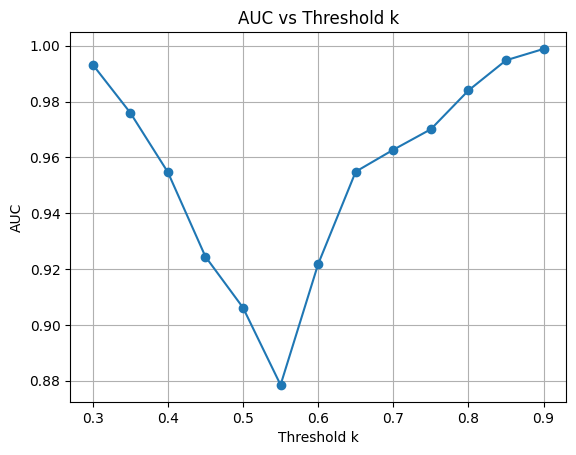

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

feature_to_preserve = 'design'
vif_df = calculate_vif(X)
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    if max_vif_feature == feature_to_preserve:
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        X.drop(max_vif_feature, axis=1, inplace=True)
    vif_df = calculate_vif(X)

# Ensure X and y have the same index
auc_scores = []
k_values = np.arange(0.3, 0.95, 0.05)
for k in k_values:
    y = (data['Y'] > k).astype(int)
    common_index = X.index.intersection(y.index)
    X_filtered = X.loc[common_index]
    y_filtered = y.loc[common_index]
    
    X_intercept = sm.add_constant(X_filtered)
    
    try:
        logit_model = sm.Logit(y_filtered, X_intercept).fit(disp=0)
        predicted_probs = logit_model.predict(X_intercept)
    except:
        logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
        logit_model.fit(X_filtered, y_filtered)
        predicted_probs = logit_model.predict_proba(X_filtered)[:, 1]
    
    auc = roc_auc_score(y_filtered, predicted_probs)
    auc_scores.append(auc)
    print(f"k: {k:.2f}, AUC: {auc:.4f}")

# Plot AUC vs k
plt.plot(k_values, auc_scores, marker='o')
plt.xlabel('Threshold k')
plt.ylabel('AUC')
plt.title('AUC vs Threshold k')
plt.grid()
plt.show()

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


k: 0.30, AUC: 0.9933, Coef Design: nan, P-value Design: nan
k: 0.35, AUC: 0.9760, Coef Design: -0.2128, P-value Design: 0.5127
k: 0.40, AUC: 0.9547, Coef Design: 0.0727, P-value Design: 0.7427
k: 0.45, AUC: 0.9245, Coef Design: 0.0246, P-value Design: 0.8833
k: 0.50, AUC: 0.9062, Coef Design: 0.0640, P-value Design: 0.6347
k: 0.55, AUC: 0.8785, Coef Design: 0.1388, P-value Design: 0.1932
k: 0.60, AUC: 0.9218, Coef Design: 0.2771, P-value Design: 0.0205
k: 0.65, AUC: 0.9549, Coef Design: 0.5089, P-value Design: 0.0008
k: 0.70, AUC: 0.9627, Coef Design: 0.1754, P-value Design: 0.2677
k: 0.75, AUC: 0.9701, Coef Design: 0.3948, P-value Design: 0.0346
k: 0.80, AUC: 0.9840, Coef Design: 0.4931, P-value Design: 0.0428
k: 0.85, AUC: 0.9948, Coef Design: 0.3738, P-value Design: 0.5771
k: 0.90, AUC: 0.9989, Coef Design: nan, P-value Design: nan


c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


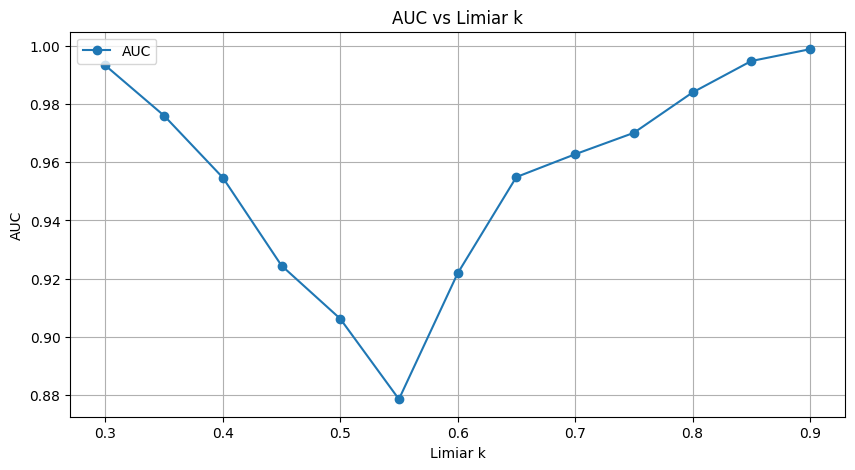

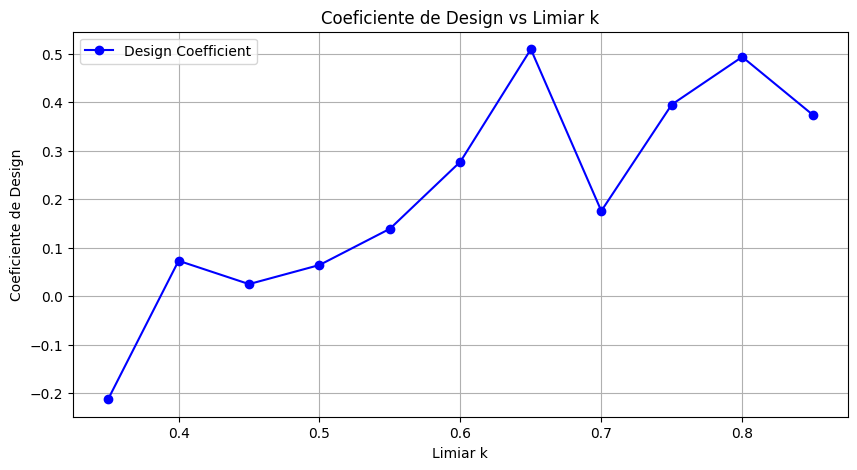

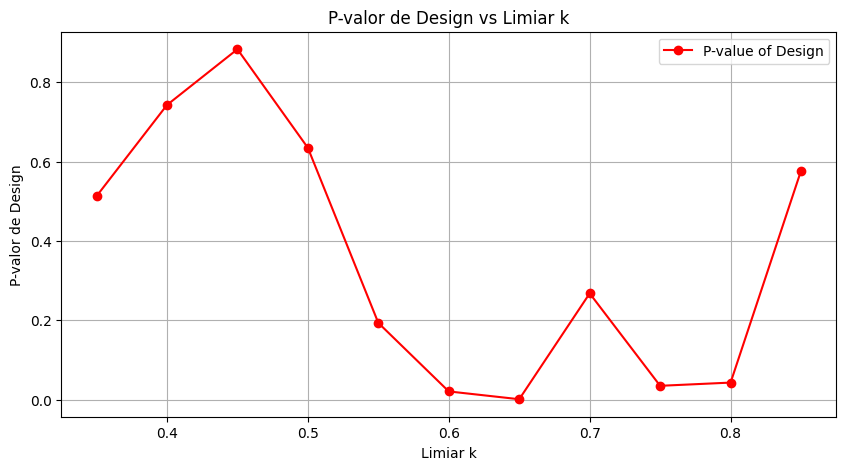

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

feature_to_preserve = 'design'
vif_df = calculate_vif(X)
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    if max_vif_feature == feature_to_preserve:
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        X.drop(max_vif_feature, axis=1, inplace=True)
    vif_df = calculate_vif(X)

# Ensure X and y have the same index
auc_scores = []
k_values = np.arange(0.3, 0.95, 0.05)
design_coefs = []
design_pvals = []

for k in k_values:
    y = (data['Y'] > k).astype(int)
    common_index = X.index.intersection(y.index)
    X_filtered = X.loc[common_index]
    y_filtered = y.loc[common_index]
    
    X_intercept = sm.add_constant(X_filtered)
    
    try:
        logit_model = sm.Logit(y_filtered, X_intercept).fit(disp=0)
        predicted_probs = logit_model.predict(X_intercept)
        coef_design = logit_model.params.get('design', np.nan)
        pval_design = logit_model.pvalues.get('design', np.nan)
    except:
        logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
        logit_model.fit(X_filtered, y_filtered)
        predicted_probs = logit_model.predict_proba(X_filtered)[:, 1]
        coef_design = np.nan
        pval_design = np.nan
    
    auc = roc_auc_score(y_filtered, predicted_probs)
    auc_scores.append(auc)
    design_coefs.append(coef_design)
    design_pvals.append(pval_design)
    print(f"k: {k:.2f}, AUC: {auc:.4f}, Coef Design: {coef_design:.4f}, P-value Design: {pval_design:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(k_values, auc_scores, marker='o', label='AUC')
plt.xlabel('Limiar k')
plt.ylabel('AUC')
plt.title('AUC vs Limiar k')
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(k_values, design_coefs, marker='o', label='Design Coefficient', color='blue')
plt.xlabel('Limiar k')
plt.ylabel('Coeficiente de Design')
plt.title('Coeficiente de Design vs Limiar k')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, design_pvals, marker='o', label='P-value of Design', color='red')
plt.xlabel('Limiar k')
plt.ylabel('P-valor de Design')
plt.title('P-valor de Design vs Limiar k')
plt.grid()
plt.legend()
plt.show()

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


k: 0.35, AUC: 0.9760, Coef Design: -0.2128, P-value Design: 0.5127
k: 0.40, AUC: 0.9547, Coef Design: 0.0727, P-value Design: 0.7427
k: 0.45, AUC: 0.9245, Coef Design: 0.0246, P-value Design: 0.8833
k: 0.50, AUC: 0.9062, Coef Design: 0.0640, P-value Design: 0.6347
k: 0.55, AUC: 0.8785, Coef Design: 0.1388, P-value Design: 0.1932
k: 0.60, AUC: 0.9218, Coef Design: 0.2771, P-value Design: 0.0205
k: 0.65, AUC: 0.9549, Coef Design: 0.5089, P-value Design: 0.0008
k: 0.70, AUC: 0.9627, Coef Design: 0.1754, P-value Design: 0.2677
k: 0.75, AUC: 0.9701, Coef Design: 0.3948, P-value Design: 0.0346
k: 0.80, AUC: 0.9840, Coef Design: 0.4931, P-value Design: 0.0428
k: 0.85, AUC: 0.9948, Coef Design: 0.3738, P-value Design: 0.5771
       k  Coeficiente de Design  P-valor de Design       AUC
0   0.35              -0.212784           0.512716  0.976007
1   0.40               0.072724           0.742667  0.954714
2   0.45               0.024607           0.883345  0.924463
3   0.50               0.0639

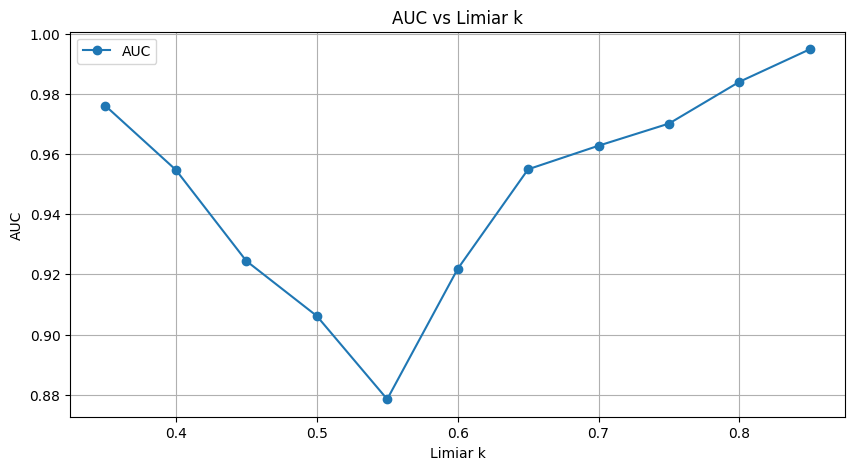

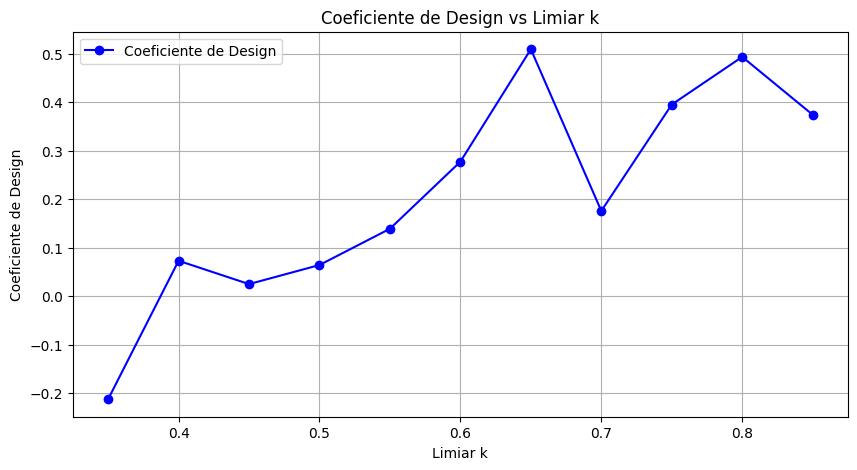

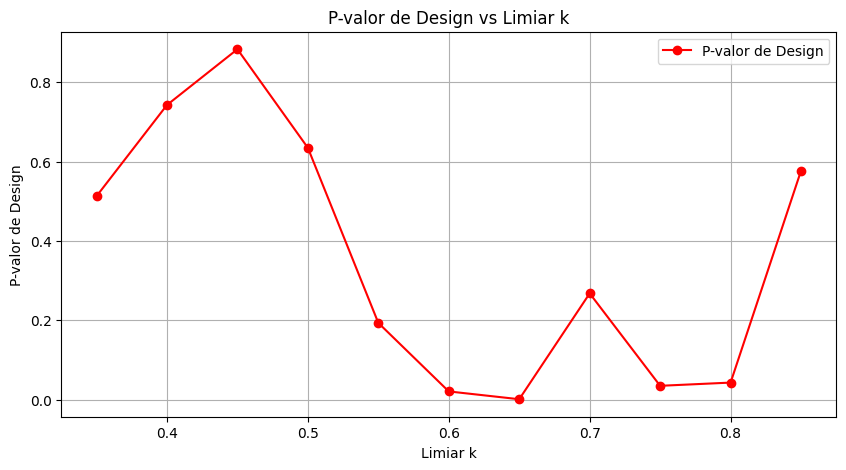

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

feature_to_preserve = 'design'
vif_df = calculate_vif(X)
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    if max_vif_feature == feature_to_preserve:
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        X.drop(max_vif_feature, axis=1, inplace=True)
    vif_df = calculate_vif(X)

# Ensure X and y have the same index
auc_scores = []
k_values = np.arange(0.35, 0.9, 0.05)
design_coefs = []
design_pvals = []

for k in k_values:
    y = (data['Y'].abs() > k).astype(int)
    common_index = X.index.intersection(y.index)
    X_filtered = X.loc[common_index]
    y_filtered = y.loc[common_index]
    
    X_intercept = sm.add_constant(X_filtered)
    
    try:
        logit_model = sm.Logit(y_filtered, X_intercept).fit(disp=0)
        predicted_probs = logit_model.predict(X_intercept)
        coef_design = logit_model.params.get('design', np.nan)
        pval_design = logit_model.pvalues.get('design', np.nan)
    except:
        logit_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
        logit_model.fit(X_filtered, y_filtered)
        predicted_probs = logit_model.predict_proba(X_filtered)[:, 1]
        coef_design = np.nan
        pval_design = np.nan
    
    auc = roc_auc_score(y_filtered, predicted_probs)
    auc_scores.append(auc)
    design_coefs.append(coef_design)
    design_pvals.append(pval_design)
    print(f"k: {k:.2f}, AUC: {auc:.4f}, Coef Design: {coef_design:.4f}, P-value Design: {pval_design:.4f}")

results_df = pd.DataFrame({
    'k': k_values,
    'Coeficiente de Design': design_coefs,
    'P-valor de Design': design_pvals,
    'AUC': auc_scores
})
print(results_df)

# Plot AUC vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, auc_scores, marker='o', label='AUC')
plt.xlabel('Limiar k')
plt.ylabel('AUC')
plt.title('AUC vs Limiar k')
plt.grid()
plt.legend()
plt.show()

# Plot Design Coefficient vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, design_coefs, marker='o', label='Coeficiente de Design', color='blue')
plt.xlabel('Limiar k')
plt.ylabel('Coeficiente de Design')
plt.title('Coeficiente de Design vs Limiar k')
plt.grid()
plt.legend()
plt.show()

# Plot P-value of Design vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, design_pvals, marker='o', label='P-valor de Design', color='red')
plt.xlabel('Limiar k')
plt.ylabel('P-valor de Design')
plt.title('P-valor de Design vs Limiar k')
plt.grid()
plt.legend()
plt.show()

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


k: 0.00, R2 Adjusted: 0.6358, Coef Design: 0.0071, P-value Design: 0.0349
k: 0.05, R2 Adjusted: 0.6373, Coef Design: 0.0072, P-value Design: 0.0283
k: 0.10, R2 Adjusted: 0.6373, Coef Design: 0.0072, P-value Design: 0.0283
k: 0.15, R2 Adjusted: 0.6460, Coef Design: 0.0082, P-value Design: 0.0106
k: 0.20, R2 Adjusted: 0.6502, Coef Design: 0.0073, P-value Design: 0.0216
k: 0.25, R2 Adjusted: 0.6576, Coef Design: 0.0074, P-value Design: 0.0165
k: 0.30, R2 Adjusted: 0.6612, Coef Design: 0.0092, P-value Design: 0.0020
k: 0.35, R2 Adjusted: 0.6778, Coef Design: 0.0086, P-value Design: 0.0025
k: 0.40, R2 Adjusted: 0.6979, Coef Design: 0.0089, P-value Design: 0.0008
k: 0.45, R2 Adjusted: 0.7044, Coef Design: 0.0082, P-value Design: 0.0013
k: 0.50, R2 Adjusted: 0.7086, Coef Design: 0.0081, P-value Design: 0.0010
k: 0.55, R2 Adjusted: 0.7186, Coef Design: 0.0067, P-value Design: 0.0045
k: 0.60, R2 Adjusted: 0.6621, Coef Design: 0.0062, P-value Design: 0.0142
k: 0.65, R2 Adjusted: 0.6137, Coef Des

c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Raissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


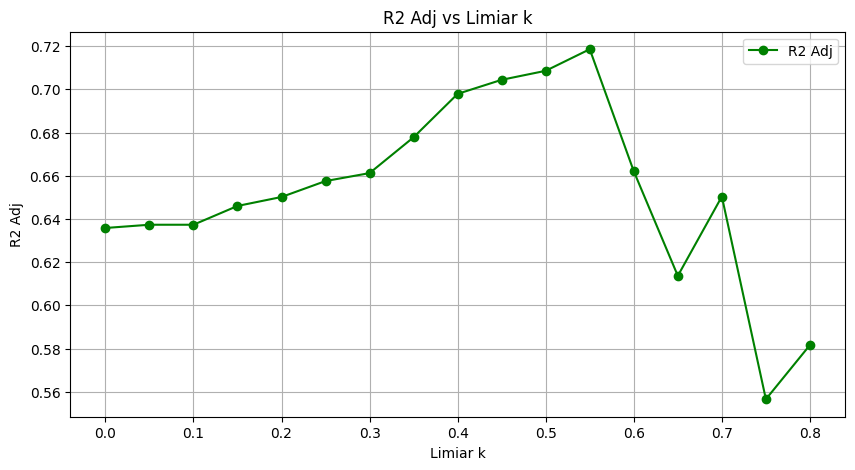

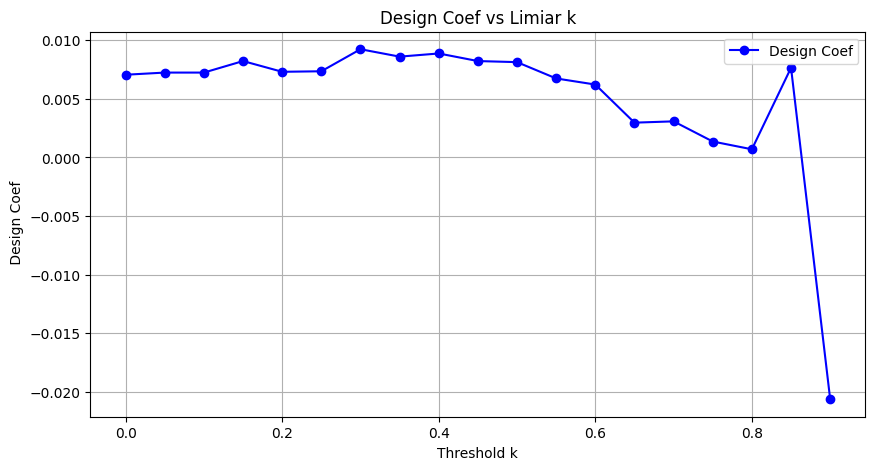

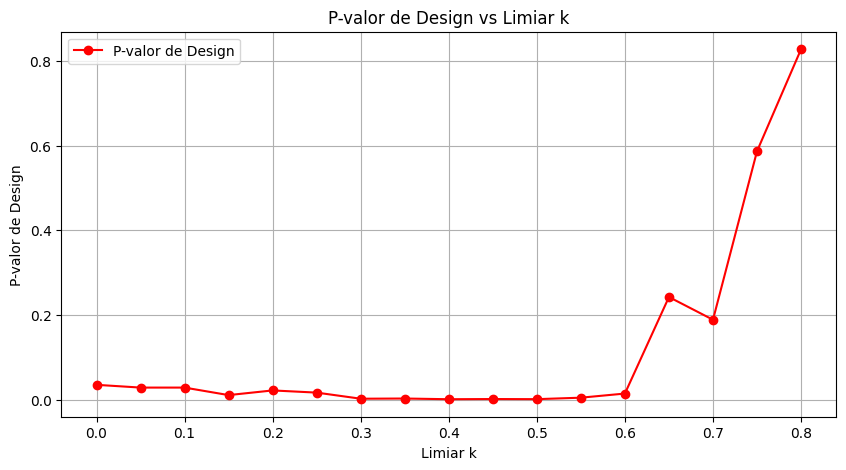

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
census_path = './census_var_clean.csv'
df_census = pd.read_csv(census_path)

csv_tags_votes = 'chicago_design_votes_tract.csv'
df_tags_votes = pd.read_csv(csv_tags_votes)

# Merge data
df_tags_census = pd.merge(df_tags_votes, df_census, on=['tract'])

# Prepare data
data = df_tags_census._get_numeric_data()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Drop unnecessary columns
X = data.drop(columns=['tract', 'Y', 'n_lightfoot_l_2019r', 'n_preckwinkle_t_2019r'])

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=data.index)

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

feature_to_preserve = 'design'
vif_df = calculate_vif(X)
threshold = 5
while vif_df['VIF'].max() > threshold:
    max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    if max_vif_feature == feature_to_preserve:
        filtered_vif_df = vif_df[vif_df['Feature'] != feature_to_preserve]
        next_max_vif_feature = filtered_vif_df.loc[filtered_vif_df['VIF'].idxmax(), 'Feature']
        X.drop(next_max_vif_feature, axis=1, inplace=True)
    else:
        X.drop(max_vif_feature, axis=1, inplace=True)
    vif_df = calculate_vif(X)

# Ensure X and y have the same index
r2_adj_scores = []
k_values = np.arange(0.0, 0.95, 0.05)
design_coefs = []
design_pvals = []

for k in k_values:
    y = data[data['Y'] > k]['Y']
    common_index = X.index.intersection(y.index)
    X_filtered = X.loc[common_index]
    y_filtered = y.loc[common_index]
    
    X_intercept = sm.add_constant(X_filtered)
    
    model = sm.OLS(y_filtered, X_intercept).fit()
    coef_design = model.params.get('design', np.nan)
    pval_design = model.pvalues.get('design', np.nan)
    r2_adj = model.rsquared_adj
    
    r2_adj_scores.append(r2_adj)
    design_coefs.append(coef_design)
    design_pvals.append(pval_design)
    print(f"k: {k:.2f}, R2 Adjusted: {r2_adj:.4f}, Coef Design: {coef_design:.4f}, P-value Design: {pval_design:.4f}")

# Create results table
results_df = pd.DataFrame({
    'k': k_values,
    'Coefficient of Design': design_coefs,
    'P-value of Design': design_pvals,
    'R2 Adjusted': r2_adj_scores
})
print(results_df)

# Plot R2 Adjusted vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, r2_adj_scores, marker='o', label='R2 Adj', color='green')
plt.xlabel('Limiar k')
plt.ylabel('R2 Adj')
plt.title('R2 Adj vs Limiar k')
plt.grid()
plt.legend()
plt.show()

# Plot Design Coefficient vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, design_coefs, marker='o', label='Design Coef', color='blue')
plt.xlabel('Threshold k')
plt.ylabel(' Design Coef')
plt.title('Design Coef vs Limiar k')
plt.grid()
plt.legend()
plt.show()

# Plot P-value of Design vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, design_pvals, marker='o', label='P-valor de Design', color='red')
plt.xlabel('Limiar k')
plt.ylabel('P-valor de Design')
plt.title('P-valor de Design vs Limiar k')
plt.grid()
plt.legend()
plt.show()